
Processing Frequency Band: delta
Alzheimer's Disease: Total Subjects = 36

Overall Most Common Outgoing Channels (group-level):
C4: 25 subjects, Mean Influence: 9.03
C3: 22 subjects, Mean Influence: 9.02
Cz: 19 subjects, Mean Influence: 9.03
Pz: 15 subjects, Mean Influence: 9.02
P4: 14 subjects, Mean Influence: 9.02

Overall Most Common Incoming Channels (group-level):
Fz: 19 subjects, Mean Influence: 9.03
F7: 17 subjects, Mean Influence: 9.03
O1: 16 subjects, Mean Influence: 9.02
T3: 16 subjects, Mean Influence: 9.02
F8: 15 subjects, Mean Influence: 9.02

Overall Most Common Connections (group-level):
C4 -> F7: 8 subjects, Mean Strength: 0.50
Cz -> F7: 6 subjects, Mean Strength: 0.50
C3 -> F7: 5 subjects, Mean Strength: 0.50
Cz -> Fz: 5 subjects, Mean Strength: 0.51
C4 -> Fz: 5 subjects, Mean Strength: 0.51


Control: Total Subjects = 29

Overall Most Common Outgoing Channels (group-level):
F3: 16 subjects, Mean Influence: 9.03
F4: 12 subjects, Mean Influence: 9.03
C3: 11 subjects, M

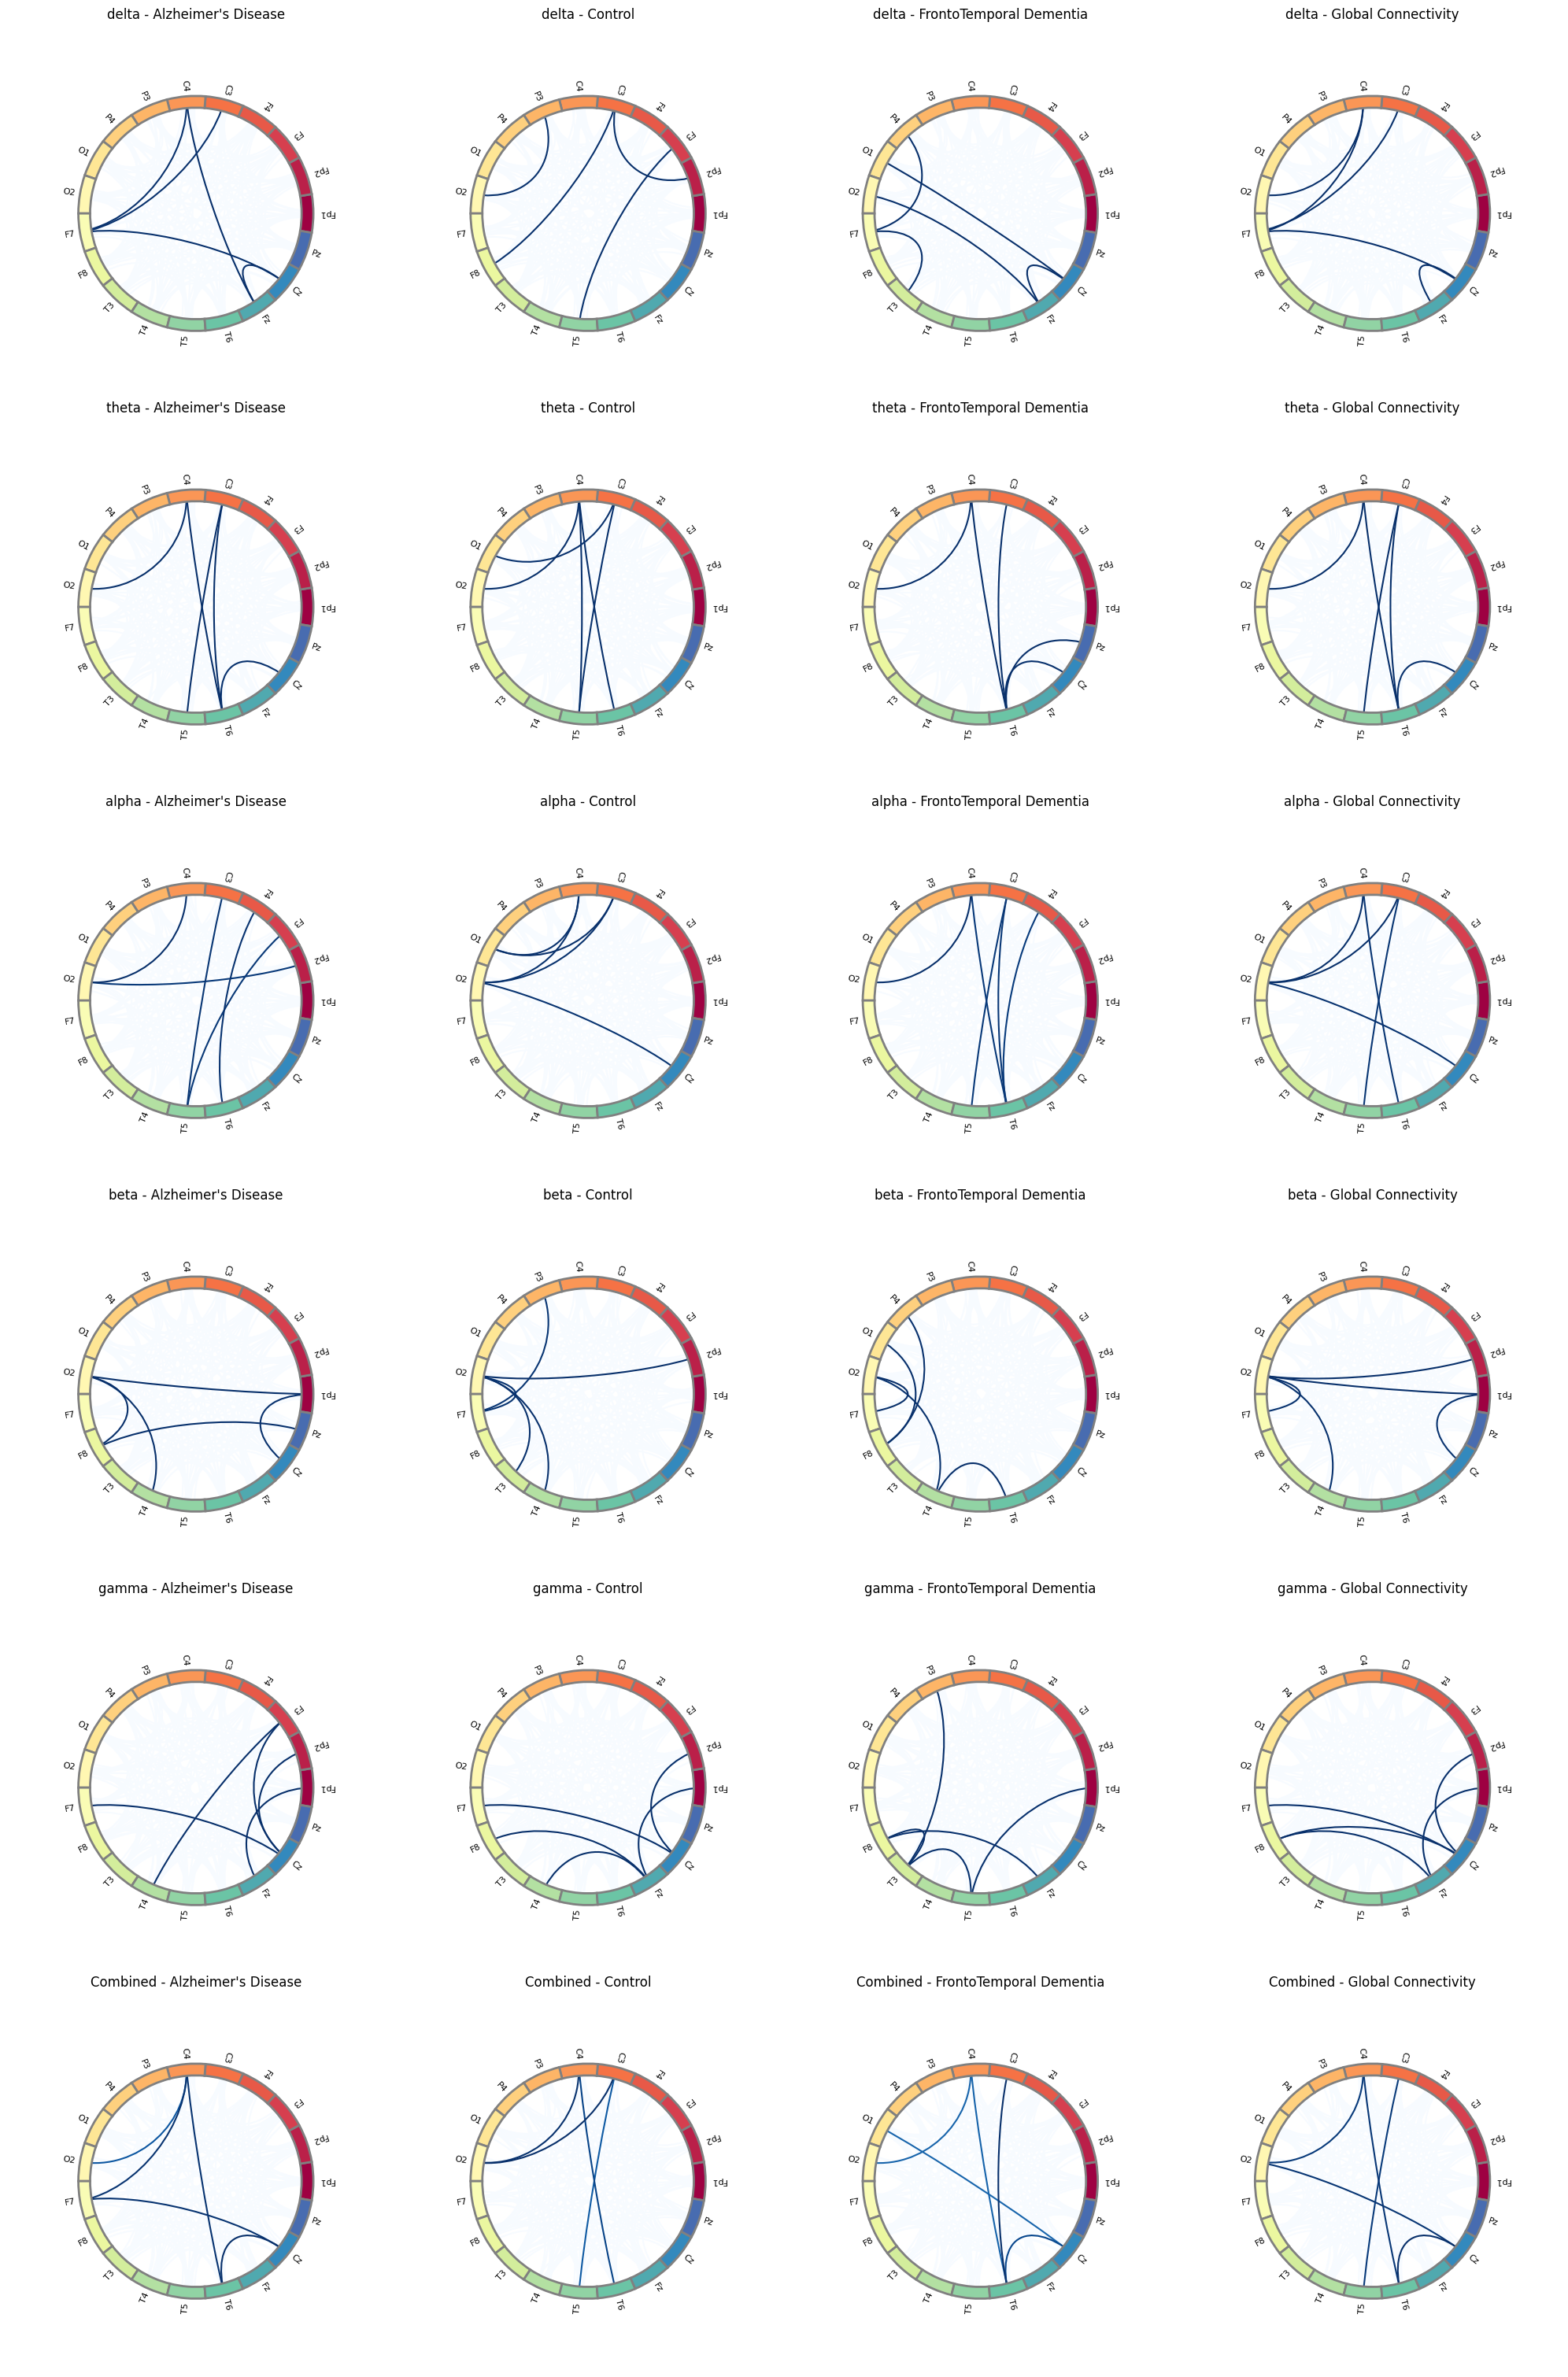

In [8]:
#Final

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import seaborn as sns
from mne_connectivity.viz import plot_connectivity_circle

# 19 EEG channels (Standard 10-20 system, example order):
DEFAULT_CHANNELS = [
    'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
    'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'
]

# ================================
# 1. Subject-level Processing
# ================================
def process_subject(dPTE_matrix, ch_names, TOP_N):
    """
    Identifies the top N outgoing, incoming channels and top N connections based on dPTE_matrix.
    Returns:
        top_outgoing: list of (channel_name, total_outgoing)
        top_incoming: list of (channel_name, total_incoming)
        top_connections: list of ((src_channel, tgt_channel), connection_strength)
    """
    # Sum row-wise and column-wise
    total_outgoing = dPTE_matrix.sum(axis=1)
    total_incoming = dPTE_matrix.sum(axis=0)

    # Get top N by descending order
    top_outgoing_indices = np.argsort(-total_outgoing)[:TOP_N]
    top_incoming_indices = np.argsort(-total_incoming)[:TOP_N]

    # Flatten matrix for top connections
    flat_indices = np.argsort(-dPTE_matrix, axis=None)[:TOP_N]
    top_conn_indices = np.unravel_index(flat_indices, dPTE_matrix.shape)

    # Create lists
    top_outgoing = [
        (ch_names[i], total_outgoing[i]) for i in top_outgoing_indices
    ]
    top_incoming = [
        (ch_names[i], total_incoming[i]) for i in top_incoming_indices
    ]
    top_connections = [
        ((ch_names[i], ch_names[j]), dPTE_matrix[i, j])
        for i, j in zip(*top_conn_indices)
    ]

    return top_outgoing, top_incoming, top_connections

# ================================
# 2. Mean Calculation
# ================================
def calculate_mean(tracked_data, key):
    """
    tracked_data[item] = {
       'subjects': set([...]),
       'sum_influence' or 'sum_strength': float
    }
    Returns a list sorted by number_of_subjects descending:
        (item, num_subjects, mean_value)
    """
    result = []
    for item, data in tracked_data.items():
        num_subjects = len(data['subjects'])
        sum_val = data[key]
        mean_val = sum_val / num_subjects if num_subjects > 0 else 0
        result.append((item, num_subjects, mean_val))

    # Sort by the number of subjects descending
    return sorted(result, key=lambda x: x[1], reverse=True)

# ================================
# 3. Group-level Processing
# ================================
def process_group(dataset_path, group_label, FREQ_BANDS, TOP_N_SUBJECTS, TOP_N_RANKINGS_OVERALL, global_tracker):
    """
    Processes a single group's .npz dataset, updates trackers, and returns the top group-level items.
    """
    try:
        data = np.load(dataset_path, allow_pickle=True)
    except FileNotFoundError:
        print(f"[ERROR] File not found: {dataset_path}")
        return [], [], []
    except Exception as e:
        print(f"[ERROR] Loading {dataset_path} => {e}")
        return [], [], []

    # Group-specific tracker
    group_tracker = {
        'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
        'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
        'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
    }

    dPTE_matrices = None
    channel_names = None

    # Iterate over each band
    for band in FREQ_BANDS:
        if band not in data:
            print(f"[WARNING] Band '{band}' not in {dataset_path}")
            continue

        band_data = data[band].item()
        if 'dPTE' not in band_data or 'channel_names' not in band_data:
            print(f"[WARNING] Missing 'dPTE' or 'channel_names' in band '{band}' => {dataset_path}")
            continue

        dPTE_matrices = band_data['dPTE']  # (#subjects, #channels, #channels)
        channel_names = band_data['channel_names']

        # Check for mismatches (optional handling)
        mismatches = set(channel_names) - set(DEFAULT_CHANNELS)
        if mismatches:
            print(f"[WARNING] Mismatched channels: {mismatches}")

        # For each subject's matrix
        for subj_index, dPTE_matrix in enumerate(dPTE_matrices):
            subject_id = f"{group_label}_subj_{subj_index}"
            top_outgoing, top_incoming, top_connections = process_subject(
                dPTE_matrix, channel_names, TOP_N_SUBJECTS
            )

            # Update group & global trackers
            # Outgoing
            for ch, influence in top_outgoing:
                group_tracker['outgoing'][ch]['subjects'].add(subject_id)
                group_tracker['outgoing'][ch]['sum_influence'] += influence

                global_tracker['outgoing'][ch]['subjects'].add(subject_id)
                global_tracker['outgoing'][ch]['sum_influence'] += influence

            # Incoming
            for ch, influence in top_incoming:
                group_tracker['incoming'][ch]['subjects'].add(subject_id)
                group_tracker['incoming'][ch]['sum_influence'] += influence

                global_tracker['incoming'][ch]['subjects'].add(subject_id)
                global_tracker['incoming'][ch]['sum_influence'] += influence

            # Connections
            for (src, tgt), strength in top_connections:
                group_tracker['connections'][(src, tgt)]['subjects'].add(subject_id)
                group_tracker['connections'][(src, tgt)]['sum_strength'] += strength

                global_tracker['connections'][(src, tgt)]['subjects'].add(subject_id)
                global_tracker['connections'][(src, tgt)]['sum_strength'] += strength

    if dPTE_matrices is None:
        # No valid data found
        return [], [], []

    # Now compute group-level stats
    outgoing_stats = calculate_mean(group_tracker['outgoing'], 'sum_influence')
    incoming_stats = calculate_mean(group_tracker['incoming'], 'sum_influence')
    connections_stats = calculate_mean(group_tracker['connections'], 'sum_strength')

    # Take top N in each category
    top_outgoing    = outgoing_stats[:TOP_N_RANKINGS_OVERALL]
    top_incoming    = incoming_stats[:TOP_N_RANKINGS_OVERALL]
    top_connections = connections_stats[:TOP_N_RANKINGS_OVERALL]

    # Print group-level summary
    total_subjects = len(dPTE_matrices)  # from the last band
    print(f"{group_label}: Total Subjects = {total_subjects}")

    print("\nOverall Most Common Outgoing Channels (group-level):")
    for ch, count, mean_influence in top_outgoing:
        print(f"{ch}: {count} subjects, Mean Influence: {mean_influence:.2f}")

    print("\nOverall Most Common Incoming Channels (group-level):")
    for ch, count, mean_influence in top_incoming:
        print(f"{ch}: {count} subjects, Mean Influence: {mean_influence:.2f}")

    print("\nOverall Most Common Connections (group-level):")
    for (src, tgt), count, mean_strength in top_connections:
        print(f"{src} -> {tgt}: {count} subjects, Mean Strength: {mean_strength:.2f}")

    print("\n" + "=" * 60 + "\n")

    # Return top items for building adjacency matrices later
    return top_outgoing, top_incoming, top_connections

# ================================
# 4. Utility: Count Group Proportions
# ================================
def calculate_group_proportions(subject_ids, group_labels):
    """
    For each subject ID, see which group it belongs to, count them up, compute proportions.
    """
    group_counts = defaultdict(int)
    for subj in subject_ids:
        for lbl in group_labels:
            if subj.startswith(lbl):
                group_counts[lbl] += 1
                break

    total = sum(group_counts.values())
    group_props = {}
    for lbl, ct in group_counts.items():
        pct = (ct / total) * 100 if total > 0 else 0
        group_props[lbl] = (ct, pct)
    return group_props

# ================================
# 5. Build Adjacency Matrix
# ================================
def build_top_connections_matrix(top_connections, channel_list):
    """
    Takes a list of top connections: [((src, tgt), count, mean_strength), ...]
    Returns a 2D array, shape = (len(channel_list), len(channel_list)).
    matrix[i, j] = mean_strength if (src->tgt) is in top_connections, else 0.
    """
    size = len(channel_list)
    mat = np.zeros((size, size), dtype=np.float32)

    for (src, tgt), count, mean_strength in top_connections:
        i = channel_list.index(src)
        j = channel_list.index(tgt)
        mat[i, j] = mean_strength
        mat[j, i] = mean_strength  # Assuming undirected connection

    return mat


# === ADDED FOR GLOBAL ANALYSIS ===
def print_global_top_items(
    top_items,
    category,
    key_names,
    tracker_key,
    global_tracker,
    datasets
):
    """
    Prints the top items in a global sense, along with group-level proportions.
    """
    print(f"Global Most Common {category}:")
    # We rely on the stored 'subjects' in global_tracker[tracker_key][...]['subjects']
    for item, count, mean_value in top_items:
        subject_ids = global_tracker[tracker_key][item]['subjects']
        # Use the dataset labels to figure out which group each subject belongs to
        group_labels = [d['label'] for d in datasets]
        props = calculate_group_proportions(subject_ids, group_labels)
        props_str = ", ".join(
            f"{lbl}: {ct} ({pct:.1f}%)" for lbl, (ct, pct) in props.items()
        )

        if tracker_key != 'connections':
            # item is just a channel name
            print(f"{item}: {count} subjects, Mean {key_names}: {mean_value:.2f} | Groups: {props_str}")
        else:
            # item is a tuple (src, tgt)
            src, tgt = item
            print(f"{src} -> {tgt}: {count} subjects, Mean {key_names}: {mean_value:.2f} | Groups: {props_str}")
    print()


def main():
    # Example frequency bands
    FREQ_BANDS = ['delta', 'theta', 'alpha', 'beta', 'gamma']

    # How many top items to take
    TOP_N_SUBJECTS = 5         # per subject
    TOP_N_RANKINGS_OVERALL = 5 # group-level
    TOP_N_GLOBAL = 5           # for global analysis

    # Paths to your .npz files
    datasets = [
        {'path': './dPTE_results/dPTE_alz_results.npz',  'label': "Alzheimer's Disease"},
        {'path': './dPTE_results/dPTE_ctrl_results.npz', 'label': "Control"},
        {'path': './dPTE_results/dPTE_ftd_results.npz',  'label': "FrontoTemporal Dementia"}
    ]

    # Initialize storage for plots
    all_band_top_connections = {}

    # ============================
    # Process each frequency band
    # ============================
    for band in FREQ_BANDS:
        print(f"\nProcessing Frequency Band: {band}")
        group_top_connections = {}

        # === ADDED: We'll keep a separate global tracker per band as well ===
        global_tracker = {
            'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
            'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
            'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
        }

        # Process each dataset (group) for this band
        for d in datasets:
            g_label = d['label']
            top_outgoing, top_incoming, top_connections = process_group(
                dataset_path=d['path'],
                group_label=g_label,
                FREQ_BANDS=[band],  # Single band processing
                TOP_N_SUBJECTS=TOP_N_SUBJECTS,
                TOP_N_RANKINGS_OVERALL=TOP_N_RANKINGS_OVERALL,
                global_tracker=global_tracker
            )
            # Store top connections for adjacency matrix building
            group_top_connections[g_label] = top_connections

        # === Perform a global-level analysis just for this band ===
        global_outgoing_stats = calculate_mean(global_tracker['outgoing'], 'sum_influence')
        global_incoming_stats = calculate_mean(global_tracker['incoming'], 'sum_influence')
        global_connections_stats = calculate_mean(global_tracker['connections'], 'sum_strength')

        top_global_outgoing    = global_outgoing_stats[:TOP_N_GLOBAL]
        top_global_incoming    = global_incoming_stats[:TOP_N_GLOBAL]
        top_global_connections = global_connections_stats[:TOP_N_GLOBAL]

        print(f"=== Global Analysis for Band '{band}' ===\n")
        print_global_top_items(
            top_global_outgoing, 
            "Outgoing Channels",
            "Influence",
            "outgoing",
            global_tracker,
            datasets
        )
        print_global_top_items(
            top_global_incoming, 
            "Incoming Channels",
            "Influence",
            "incoming",
            global_tracker,
            datasets
        )
        print_global_top_items(
            top_global_connections, 
            "Connections",
            "Connection Strength",
            "connections",
            global_tracker,
            datasets
        )

        # Also store "Global" top connections for adjacency matrix
        global_matrix = calculate_mean(global_tracker['connections'], 'sum_strength')[:TOP_N_RANKINGS_OVERALL]
        group_top_connections["Global"] = global_matrix

        all_band_top_connections[band] = group_top_connections

    # ============================
    # Combined Frequency Band
    # ============================
    print("\nProcessing Combined Frequency Band")
    combined_top_connections = {}

    # Initialize a separate global tracker for the combined frequency bands
    combined_global_tracker = {
        'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
        'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
        'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
    }

    for d in datasets:
        g_label = d['label']
        top_outgoing, top_incoming, top_connections = process_group(
            dataset_path=d['path'],
            group_label=g_label,
            FREQ_BANDS=FREQ_BANDS,  # All bands combined
            TOP_N_SUBJECTS=TOP_N_SUBJECTS,
            TOP_N_RANKINGS_OVERALL=TOP_N_RANKINGS_OVERALL,
            global_tracker=combined_global_tracker
        )
        combined_top_connections[g_label] = top_connections

    # Calculate the global matrix for all bands combined (top connections)
    combined_global_matrix = calculate_mean(combined_global_tracker['connections'], 'sum_strength')[:TOP_N_RANKINGS_OVERALL]
    combined_top_connections["Global"] = combined_global_matrix

    all_band_top_connections["Combined"] = combined_top_connections

    # === ADDED: Print a global summary for the combined frequencies as well ===
    print("\n=== Global Analysis Across ALL Frequency Bands (Combined) ===\n")
    global_outgoing_stats = calculate_mean(combined_global_tracker['outgoing'], 'sum_influence')
    global_incoming_stats = calculate_mean(combined_global_tracker['incoming'], 'sum_influence')
    global_connections_stats = calculate_mean(combined_global_tracker['connections'], 'sum_strength')

    top_global_outgoing    = global_outgoing_stats[:TOP_N_GLOBAL]
    top_global_incoming    = global_incoming_stats[:TOP_N_GLOBAL]
    top_global_connections = global_connections_stats[:TOP_N_GLOBAL]

    print_global_top_items(
        top_global_outgoing, 
        "Outgoing Channels",
        "Influence",
        "outgoing",
        combined_global_tracker,
        datasets
    )
    print_global_top_items(
        top_global_incoming, 
        "Incoming Channels",
        "Influence",
        "incoming",
        combined_global_tracker,
        datasets
    )
    print_global_top_items(
        top_global_connections, 
        "Connections",
        "Connection Strength",
        "connections",
        combined_global_tracker,
        datasets
    )

    # ============================
    # Plot Results
    # ============================
    print("\nPlotting Results")
    num_rows = len(FREQ_BANDS) + 1  # 1 row per band + combined row
    num_cols = 4  # 4 groups per row (3 datasets + global)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), subplot_kw={'projection': 'polar'})
    fig.patch.set_facecolor('white')

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Iterate over frequency bands and groups
    plot_index = 0
    for band, group_top_connections in all_band_top_connections.items():
        for g_label, top_conns in group_top_connections.items():
            matrix = build_top_connections_matrix(top_conns, DEFAULT_CHANNELS)
            if g_label != "Global":
                title = f"{band} - {g_label}" if band != "Combined" else f"Combined - {g_label}"
            else:
                title = f"{band} - Global Connectivity" if band != "Combined" else "Combined - Global Connectivity"

            # Plot connectivity circle
            plot_connectivity_circle(
                con=matrix,
                node_names=DEFAULT_CHANNELS,
                textcolor='black',
                colorbar=False,  # Enable colorbar only for the last plot
                show=False,
                colormap="Blues",
                ax=axes[plot_index],
                title=title,
                node_edgecolor='gray',
                facecolor='white'
            )
            axes[plot_index].set_aspect('equal')
            plot_index += 1

    # Hide unused subplots
    for idx in range(plot_index, len(axes)):
        fig.delaxes(axes[idx])

    # Adjust layout for plots
    plt.tight_layout(pad=0.0)  # Adjust pad as needed
    plt.show()


if __name__ == "__main__":
    main()


In [9]:
# #HHIIIII

# import numpy as np
# from collections import defaultdict

# import matplotlib.pyplot as plt
# import seaborn as sns
# from mne_connectivity.viz import plot_connectivity_circle

# # 19 EEG channels (Standard 10-20 system, example order):
# DEFAULT_CHANNELS = [
#     'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
#     'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'
# ]

# # ================================
# # 1. Subject-level Processing
# # ================================
# def process_subject(dPTE_matrix, ch_names, TOP_N):
#     """
#     Identifies the top N outgoing, incoming channels and top N connections based on dPTE_matrix.
#     Returns:
#         top_outgoing: list of (channel_name, total_outgoing)
#         top_incoming: list of (channel_name, total_incoming)
#         top_connections: list of ((src_channel, tgt_channel), connection_strength)
#     """
#     # Sum row-wise and column-wise
#     total_outgoing = dPTE_matrix.sum(axis=1)
#     total_incoming = dPTE_matrix.sum(axis=0)

#     # Get top N by descending order
#     top_outgoing_indices = np.argsort(-total_outgoing)[:TOP_N]
#     top_incoming_indices = np.argsort(-total_incoming)[:TOP_N]

#     # Flatten matrix for top connections
#     flat_indices = np.argsort(-dPTE_matrix, axis=None)[:TOP_N]
#     top_conn_indices = np.unravel_index(flat_indices, dPTE_matrix.shape)

#     # Create lists
#     top_outgoing = [
#         (ch_names[i], total_outgoing[i]) for i in top_outgoing_indices
#     ]
#     top_incoming = [
#         (ch_names[i], total_incoming[i]) for i in top_incoming_indices
#     ]
#     top_connections = [
#         ((ch_names[i], ch_names[j]), dPTE_matrix[i, j])
#         for i, j in zip(*top_conn_indices)
#     ]

#     return top_outgoing, top_incoming, top_connections

# # ================================
# # 2. Mean Calculation
# # ================================
# def calculate_mean(tracked_data, key):
#     """
#     tracked_data[item] = {
#        'subjects': set([...]),
#        'sum_influence' or 'sum_strength': float
#     }
#     Returns a list sorted by number_of_subjects descending:
#         (item, num_subjects, mean_value)
#     """
#     result = []
#     for item, data in tracked_data.items():
#         num_subjects = len(data['subjects'])
#         sum_val = data[key]
#         mean_val = sum_val / num_subjects if num_subjects > 0 else 0
#         result.append((item, num_subjects, mean_val))

#     # Sort by the number of subjects descending
#     return sorted(result, key=lambda x: x[1], reverse=True)

# # ================================
# # 3. Group-level Processing
# # ================================
# def process_group(dataset_path, group_label, FREQ_BANDS, TOP_N_SUBJECTS, TOP_N_RANKINGS_OVERALL, global_tracker):
#     """
#     Processes a single group's .npz dataset, updates trackers, and returns the top group-level items.
#     """
#     try:
#         data = np.load(dataset_path, allow_pickle=True)
#     except FileNotFoundError:
#         print(f"[ERROR] File not found: {dataset_path}")
#         return [], [], []
#     except Exception as e:
#         print(f"[ERROR] Loading {dataset_path} => {e}")
#         return [], [], []

#     # Group-specific tracker
#     group_tracker = {
#         'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
#     }

#     dPTE_matrices = None
#     channel_names = None

#     # Iterate over each band
#     for band in FREQ_BANDS:
#         if band not in data:
#             print(f"[WARNING] Band '{band}' not in {dataset_path}")
#             continue

#         band_data = data[band].item()
#         if 'dPTE' not in band_data or 'channel_names' not in band_data:
#             print(f"[WARNING] Missing 'dPTE' or 'channel_names' in band '{band}' => {dataset_path}")
#             continue

#         dPTE_matrices = band_data['dPTE']  # (#subjects, #channels, #channels)
#         channel_names = band_data['channel_names']

#         # Debug: Print channel names
#         # print(f"[DEBUG] Processing band '{band}' for group '{group_label}'.")
#         # print("Channel names from NPZ:", channel_names)
#         # print("Default Channels:", DEFAULT_CHANNELS)

#         # Check for mismatches
#         mismatches = set(channel_names) - set(DEFAULT_CHANNELS)
#         if mismatches:            # Optionally, handle mismatches here (e.g., rename channels)
#             print(f"[WARNING] Mismatched channels: {mismatches}")

#         # For each subject's matrix
#         for subj_index, dPTE_matrix in enumerate(dPTE_matrices):
#             subject_id = f"{group_label}_subj_{subj_index}"
#             top_outgoing, top_incoming, top_connections = process_subject(
#                 dPTE_matrix, channel_names, TOP_N_SUBJECTS
#             )

#             # Update group & global trackers
#             # Outgoing
#             for ch, influence in top_outgoing:
#                 group_tracker['outgoing'][ch]['subjects'].add(subject_id)
#                 group_tracker['outgoing'][ch]['sum_influence'] += influence

#                 global_tracker['outgoing'][ch]['subjects'].add(subject_id)
#                 global_tracker['outgoing'][ch]['sum_influence'] += influence

#             # Incoming
#             for ch, influence in top_incoming:
#                 group_tracker['incoming'][ch]['subjects'].add(subject_id)
#                 group_tracker['incoming'][ch]['sum_influence'] += influence

#                 global_tracker['incoming'][ch]['subjects'].add(subject_id)
#                 global_tracker['incoming'][ch]['sum_influence'] += influence

#             # Connections
#             for (src, tgt), strength in top_connections:
#                 group_tracker['connections'][(src, tgt)]['subjects'].add(subject_id)
#                 group_tracker['connections'][(src, tgt)]['sum_strength'] += strength

#                 global_tracker['connections'][(src, tgt)]['subjects'].add(subject_id)
#                 global_tracker['connections'][(src, tgt)]['sum_strength'] += strength

#     if dPTE_matrices is None:
#         # No valid data found
#         return [], [], []

#     # Now compute group-level stats
#     outgoing_stats = calculate_mean(group_tracker['outgoing'], 'sum_influence')
#     incoming_stats = calculate_mean(group_tracker['incoming'], 'sum_influence')
#     connections_stats = calculate_mean(group_tracker['connections'], 'sum_strength')

#     # Take top N in each category
#     top_outgoing    = outgoing_stats[:TOP_N_RANKINGS_OVERALL]
#     top_incoming    = incoming_stats[:TOP_N_RANKINGS_OVERALL]
#     top_connections = connections_stats[:TOP_N_RANKINGS_OVERALL]

#     # Print group-level summary
#     total_subjects = len(dPTE_matrices)  # from the last band
#     print(f"{group_label}: Total Subjects = {total_subjects}")

#     print("\nOverall Most Common Outgoing Channels (group-level):")
#     for ch, count, mean_influence in top_outgoing:
#         print(f"{ch}: {count} subjects, Mean Influence: {mean_influence:.2f}")

#     print("\nOverall Most Common Incoming Channels (group-level):")
#     for ch, count, mean_influence in top_incoming:
#         print(f"{ch}: {count} subjects, Mean Influence: {mean_influence:.2f}")

#     print("\nOverall Most Common Connections (group-level):")
#     for (src, tgt), count, mean_strength in top_connections:
#         print(f"{src} -> {tgt}: {count} subjects, Mean Strength: {mean_strength:.2f}")

#     print("\n" + "=" * 60 + "\n")

#     # Return top items for building adjacency matrices later
#     return top_outgoing, top_incoming, top_connections

# # ================================
# # 4. Utility: Count Group Proportions
# # ================================
# def calculate_group_proportions(subject_ids, group_labels):
#     """
#     For each subject ID, see which group it belongs to, count them up, compute proportions.
#     """
#     group_counts = defaultdict(int)
#     for subj in subject_ids:
#         for lbl in group_labels:
#             if subj.startswith(lbl):
#                 group_counts[lbl] += 1
#                 break

#     total = sum(group_counts.values())
#     group_props = {}
#     for lbl, ct in group_counts.items():
#         pct = (ct / total) * 100 if total > 0 else 0
#         group_props[lbl] = (ct, pct)
#     return group_props

# # ================================
# # 5. Build Adjacency Matrix
# # ================================
# def build_top_connections_matrix(top_connections, channel_list):
#     """
#     Takes a list of top connections: [((src, tgt), count, mean_strength), ...]
#     Returns a 2D array, shape = (len(channel_list), len(channel_list)).
#     matrix[i, j] = mean_strength if (src->tgt) is in top_connections, else 0.
#     """
#     size = len(channel_list)
#     mat = np.zeros((size, size), dtype=np.float32)

#     for (src, tgt), count, mean_strength in top_connections:
#         i = channel_list.index(src)
#         j = channel_list.index(tgt)
#         mat[i, j] = mean_strength
#         mat[j, i] = mean_strength  # Assuming undirected connection


#     return mat

# # ================================
# # 6. Main & Global Analysis
# # ================================
# def main():
#     # Example frequency bands
#     FREQ_BANDS = ['delta', 'theta', 'alpha', 'beta', 'gamma']

#     # How many top items to take
#     TOP_N_SUBJECTS = 5         # per subject
#     TOP_N_RANKINGS_OVERALL = 5 # group-level

#     # Paths to your .npz files
#     datasets = [
#         {'path': './dPTE_results/dPTE_alz_results.npz',  'label': "Alzheimer's Disease"},
#         {'path': './dPTE_results/dPTE_ctrl_results.npz', 'label': "Control"},
#         {'path': './dPTE_results/dPTE_ftd_results.npz',  'label': "FrontoTemporal Dementia"}
#     ]

#     # Global tracker accumulates from all groups
#     global_tracker = {
#         'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
#     }

#     # For adjacency matrices per group
#     group_top_connections = {}

#     # 1) Process each dataset (group)
#     for d in datasets:
#         g_label = d['label']
#         top_outgoing, top_incoming, top_connections = process_group(
#             dataset_path=d['path'],
#             group_label=g_label,
#             FREQ_BANDS=FREQ_BANDS,
#             TOP_N_SUBJECTS=TOP_N_SUBJECTS,
#             TOP_N_RANKINGS_OVERALL=TOP_N_RANKINGS_OVERALL,
#             global_tracker=global_tracker
#         )
#         # Store the top connections for adjacency matrix building
#         group_top_connections[g_label] = top_connections

#     # 2) Global Analysis
#     print("=== Global Analysis Across All Groups ===\n")

#     # Summaries across all subjects from all groups
#     global_outgoing_stats = calculate_mean(global_tracker['outgoing'],    'sum_influence')
#     global_incoming_stats = calculate_mean(global_tracker['incoming'],    'sum_influence')
#     global_connections_stats = calculate_mean(global_tracker['connections'], 'sum_strength')

#     # Pick top 10 globally
#     TOP_N_RANKINGS_GLOBAL = 5
#     top_global_outgoing    = global_outgoing_stats[:TOP_N_RANKINGS_GLOBAL]
#     top_global_incoming    = global_incoming_stats[:TOP_N_RANKINGS_GLOBAL]
#     top_global_connections = global_connections_stats[:TOP_N_RANKINGS_GLOBAL]

#     group_labels = [d['label'] for d in datasets]

#     def print_global_top_items(top_items, category, key_names, tracker_key):
#         print(f"Global Most Common {category} (All Groups Combined):")
#         for item, count, mean_value in top_items:
#             subject_ids = global_tracker[tracker_key][item]['subjects']
#             props = calculate_group_proportions(subject_ids, group_labels)
#             props_str = ", ".join(
#                 f"{lbl}: {ct} ({pct:.1f}%)" for lbl, (ct, pct) in props.items()
#             )
#             if tracker_key != 'connections':
#                 # item is a channel
#                 print(f"{item}: {count} subjects, Mean {key_names}: {mean_value:.2f} | Groups: {props_str}")
#             else:
#                 # item is a tuple (src, tgt)
#                 src, tgt = item
#                 print(f"{src} -> {tgt}: {count} subjects, Mean {key_names}: {mean_value:.2f} | Groups: {props_str}")
#         print()

#     # Print global results
#     print_global_top_items(top_global_outgoing,    "Outgoing Channels",    "Influence",          "outgoing")
#     print_global_top_items(top_global_incoming,    "Incoming Channels",    "Influence",          "incoming")
#     print_global_top_items(top_global_connections, "Connections",          "Connection Strength","connections")

#     print("\n" + "="*60 + "\n")

#     # 3) Build adjacency matrices from top connections
#     print("=== Building 19×19 Adjacency Matrices ===\n")

#     # a) Group-level adjacency matrices (optional; commented out as per user request)


#     # Number of datasets + 1 for the global matrix
#     num_plots = len(datasets) + 1

#     # Create a single-row figure with multiple subplots
#     fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), subplot_kw={'projection': 'polar'})

#     # Set the figure background color to black
#     fig.patch.set_facecolor('black')

#     # Loop over datasets and include the global plot
#     for i in range(num_plots):
#         if i < len(datasets):
#             # Handle individual dataset plots
#             d = datasets[i]
#             g_label = d['label']
#             top_conns = group_top_connections[g_label]
#             matrix = build_top_connections_matrix(top_conns, DEFAULT_CHANNELS)
#             title = f'{g_label} Top Connections'
#             colorbar = True  # Disable colorbar for dataset plots
#         else:
#             # Handle the global plot
#             matrix = build_top_connections_matrix(top_global_connections, DEFAULT_CHANNELS)
#             title = 'Global Top Connections'
#             colorbar = True  # Enable colorbar for the global plot

#         # Plot the connectivity circle
#         plot_connectivity_circle(
#             con=matrix,
#             node_names=DEFAULT_CHANNELS,
#             textcolor='white',
#             colorbar=colorbar,  # Add colorbar only for the global plot
#             show=False,         # Do not show until all subplots are ready
#             colormap="hot",
#             ax=axes[i],         # Use the i-th subplot
#             title=title
#         )

#         # Ensure equal aspect ratio for all subplots
#         axes[i].set_aspect('equal')

#     # Show all subplots in a single row
#     plt.tight_layout()
#     plt.show()


#     return top_global_connections

# if __name__ == "__main__":
#     top_global_connections = main()


In [10]:
# #HHIIIII

# import numpy as np
# from collections import defaultdict

# import matplotlib.pyplot as plt
# import seaborn as sns
# from mne_connectivity.viz import plot_connectivity_circle

# # 19 EEG channels (Standard 10-20 system, example order):
# DEFAULT_CHANNELS = [
#     'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
#     'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'
# ]

# # ================================
# # 1. Subject-level Processing
# # ================================
# def process_subject(dPTE_matrix, ch_names, TOP_N):
#     """
#     Identifies the top N outgoing, incoming channels and top N connections based on dPTE_matrix.
#     Returns:
#         top_outgoing: list of (channel_name, total_outgoing)
#         top_incoming: list of (channel_name, total_incoming)
#         top_connections: list of ((src_channel, tgt_channel), connection_strength)
#     """
#     # Sum row-wise and column-wise
#     total_outgoing = dPTE_matrix.sum(axis=1)
#     total_incoming = dPTE_matrix.sum(axis=0)

#     # Get top N by descending order
#     top_outgoing_indices = np.argsort(-total_outgoing)[:TOP_N]
#     top_incoming_indices = np.argsort(-total_incoming)[:TOP_N]

#     # Flatten matrix for top connections
#     flat_indices = np.argsort(-dPTE_matrix, axis=None)[:TOP_N]
#     top_conn_indices = np.unravel_index(flat_indices, dPTE_matrix.shape)

#     # Create lists
#     top_outgoing = [
#         (ch_names[i], total_outgoing[i]) for i in top_outgoing_indices
#     ]
#     top_incoming = [
#         (ch_names[i], total_incoming[i]) for i in top_incoming_indices
#     ]
#     top_connections = [
#         ((ch_names[i], ch_names[j]), dPTE_matrix[i, j])
#         for i, j in zip(*top_conn_indices)
#     ]

#     return top_outgoing, top_incoming, top_connections

# # ================================
# # 2. Mean Calculation
# # ================================
# def calculate_mean(tracked_data, key):
#     """
#     tracked_data[item] = {
#        'subjects': set([...]),
#        'sum_influence' or 'sum_strength': float
#     }
#     Returns a list sorted by number_of_subjects descending:
#         (item, num_subjects, mean_value)
#     """
#     result = []
#     for item, data in tracked_data.items():
#         num_subjects = len(data['subjects'])
#         sum_val = data[key]
#         mean_val = sum_val / num_subjects if num_subjects > 0 else 0
#         result.append((item, num_subjects, mean_val))

#     # Sort by the number of subjects descending
#     return sorted(result, key=lambda x: x[1], reverse=True)

# # ================================
# # 3. Group-level Processing
# # ================================
# def process_group(dataset_path, group_label, FREQ_BANDS, TOP_N_SUBJECTS, TOP_N_RANKINGS_OVERALL, global_tracker):
#     """
#     Processes a single group's .npz dataset, updates trackers, and returns the top group-level items.
#     """
#     try:
#         data = np.load(dataset_path, allow_pickle=True)
#     except FileNotFoundError:
#         print(f"[ERROR] File not found: {dataset_path}")
#         return [], [], []
#     except Exception as e:
#         print(f"[ERROR] Loading {dataset_path} => {e}")
#         return [], [], []

#     # Group-specific tracker
#     group_tracker = {
#         'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
#     }

#     dPTE_matrices = None
#     channel_names = None

#     # Iterate over each band
#     for band in FREQ_BANDS:
#         if band not in data:
#             print(f"[WARNING] Band '{band}' not in {dataset_path}")
#             continue

#         band_data = data[band].item()
#         if 'dPTE' not in band_data or 'channel_names' not in band_data:
#             print(f"[WARNING] Missing 'dPTE' or 'channel_names' in band '{band}' => {dataset_path}")
#             continue

#         dPTE_matrices = band_data['dPTE']  # (#subjects, #channels, #channels)
#         channel_names = band_data['channel_names']

#         # Debug: Print channel names
#         # print(f"[DEBUG] Processing band '{band}' for group '{group_label}'.")
#         # print("Channel names from NPZ:", channel_names)
#         # print("Default Channels:", DEFAULT_CHANNELS)

#         # Check for mismatches
#         mismatches = set(channel_names) - set(DEFAULT_CHANNELS)
#         if mismatches:            # Optionally, handle mismatches here (e.g., rename channels)
#             print(f"[WARNING] Mismatched channels: {mismatches}")

#         # For each subject's matrix
#         for subj_index, dPTE_matrix in enumerate(dPTE_matrices):
#             subject_id = f"{group_label}_subj_{subj_index}"
#             top_outgoing, top_incoming, top_connections = process_subject(
#                 dPTE_matrix, channel_names, TOP_N_SUBJECTS
#             )

#             # Update group & global trackers
#             # Outgoing
#             for ch, influence in top_outgoing:
#                 group_tracker['outgoing'][ch]['subjects'].add(subject_id)
#                 group_tracker['outgoing'][ch]['sum_influence'] += influence

#                 global_tracker['outgoing'][ch]['subjects'].add(subject_id)
#                 global_tracker['outgoing'][ch]['sum_influence'] += influence

#             # Incoming
#             for ch, influence in top_incoming:
#                 group_tracker['incoming'][ch]['subjects'].add(subject_id)
#                 group_tracker['incoming'][ch]['sum_influence'] += influence

#                 global_tracker['incoming'][ch]['subjects'].add(subject_id)
#                 global_tracker['incoming'][ch]['sum_influence'] += influence

#             # Connections
#             for (src, tgt), strength in top_connections:
#                 group_tracker['connections'][(src, tgt)]['subjects'].add(subject_id)
#                 group_tracker['connections'][(src, tgt)]['sum_strength'] += strength

#                 global_tracker['connections'][(src, tgt)]['subjects'].add(subject_id)
#                 global_tracker['connections'][(src, tgt)]['sum_strength'] += strength

#     if dPTE_matrices is None:
#         # No valid data found
#         return [], [], []

#     # Now compute group-level stats
#     outgoing_stats = calculate_mean(group_tracker['outgoing'], 'sum_influence')
#     incoming_stats = calculate_mean(group_tracker['incoming'], 'sum_influence')
#     connections_stats = calculate_mean(group_tracker['connections'], 'sum_strength')

#     # Take top N in each category
#     top_outgoing    = outgoing_stats[:TOP_N_RANKINGS_OVERALL]
#     top_incoming    = incoming_stats[:TOP_N_RANKINGS_OVERALL]
#     top_connections = connections_stats[:TOP_N_RANKINGS_OVERALL]

#     # Print group-level summary
#     total_subjects = len(dPTE_matrices)  # from the last band
#     print(f"{group_label}: Total Subjects = {total_subjects}")

#     print("\nOverall Most Common Outgoing Channels (group-level):")
#     for ch, count, mean_influence in top_outgoing:
#         print(f"{ch}: {count} subjects, Mean Influence: {mean_influence:.2f}")

#     print("\nOverall Most Common Incoming Channels (group-level):")
#     for ch, count, mean_influence in top_incoming:
#         print(f"{ch}: {count} subjects, Mean Influence: {mean_influence:.2f}")

#     print("\nOverall Most Common Connections (group-level):")
#     for (src, tgt), count, mean_strength in top_connections:
#         print(f"{src} -> {tgt}: {count} subjects, Mean Strength: {mean_strength:.2f}")

#     print("\n" + "=" * 60 + "\n")

#     # Return top items for building adjacency matrices later
#     return top_outgoing, top_incoming, top_connections

# # ================================
# # 4. Utility: Count Group Proportions
# # ================================
# def calculate_group_proportions(subject_ids, group_labels):
#     """
#     For each subject ID, see which group it belongs to, count them up, compute proportions.
#     """
#     group_counts = defaultdict(int)
#     for subj in subject_ids:
#         for lbl in group_labels:
#             if subj.startswith(lbl):
#                 group_counts[lbl] += 1
#                 break

#     total = sum(group_counts.values())
#     group_props = {}
#     for lbl, ct in group_counts.items():
#         pct = (ct / total) * 100 if total > 0 else 0
#         group_props[lbl] = (ct, pct)
#     return group_props

# # ================================
# # 5. Build Adjacency Matrix
# # ================================
# def build_top_connections_matrix(top_connections, channel_list):
#     """
#     Takes a list of top connections: [((src, tgt), count, mean_strength), ...]
#     Returns a 2D array, shape = (len(channel_list), len(channel_list)).
#     matrix[i, j] = mean_strength if (src->tgt) is in top_connections, else 0.
#     """
#     size = len(channel_list)
#     mat = np.zeros((size, size), dtype=np.float32)

#     for (src, tgt), count, mean_strength in top_connections:
#         i = channel_list.index(src)
#         j = channel_list.index(tgt)
#         mat[i, j] = mean_strength
#         mat[j, i] = mean_strength  # Assuming undirected connection


#     return mat

# # ================================
# # 6. Main & Global Analysis
# # ================================
# def main():
#     # Example frequency bands
#     FREQ_BANDS = ['delta']

#     # How many top items to take
#     TOP_N_SUBJECTS = 5         # per subject
#     TOP_N_RANKINGS_OVERALL = 5 # group-level

#     # Paths to your .npz files
#     datasets = [
#         {'path': './new_arrays/dPTE_alz_results.npz',  'label': "Alzheimer's Disease"},
#         {'path': './new_arrays/dPTE_ctrl_results.npz', 'label': "Control"},
#         {'path': './new_arrays/dPTE_ftd_results.npz',  'label': "FrontoTemporal Dementia"}
#     ]

#     # Global tracker accumulates from all groups
#     global_tracker = {
#         'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
#     }

#     # For adjacency matrices per group
#     group_top_connections = {}

#     # 1) Process each dataset (group)
#     for d in datasets:
#         g_label = d['label']
#         top_outgoing, top_incoming, top_connections = process_group(
#             dataset_path=d['path'],
#             group_label=g_label,
#             FREQ_BANDS=FREQ_BANDS,
#             TOP_N_SUBJECTS=TOP_N_SUBJECTS,
#             TOP_N_RANKINGS_OVERALL=TOP_N_RANKINGS_OVERALL,
#             global_tracker=global_tracker
#         )
#         # Store the top connections for adjacency matrix building
#         group_top_connections[g_label] = top_connections

#     # 2) Global Analysis
#     print("=== Global Analysis Across All Groups ===\n")

#     # Summaries across all subjects from all groups
#     global_outgoing_stats = calculate_mean(global_tracker['outgoing'],    'sum_influence')
#     global_incoming_stats = calculate_mean(global_tracker['incoming'],    'sum_influence')
#     global_connections_stats = calculate_mean(global_tracker['connections'], 'sum_strength')

#     # Pick top 10 globally
#     TOP_N_RANKINGS_GLOBAL = 10
#     top_global_outgoing    = global_outgoing_stats[:TOP_N_RANKINGS_GLOBAL]
#     top_global_incoming    = global_incoming_stats[:TOP_N_RANKINGS_GLOBAL]
#     top_global_connections = global_connections_stats[:TOP_N_RANKINGS_GLOBAL]

#     group_labels = [d['label'] for d in datasets]

#     def print_global_top_items(top_items, category, key_names, tracker_key):
#         print(f"Global Most Common {category} (All Groups Combined):")
#         for item, count, mean_value in top_items:
#             subject_ids = global_tracker[tracker_key][item]['subjects']
#             props = calculate_group_proportions(subject_ids, group_labels)
#             props_str = ", ".join(
#                 f"{lbl}: {ct} ({pct:.1f}%)" for lbl, (ct, pct) in props.items()
#             )
#             if tracker_key != 'connections':
#                 # item is a channel
#                 print(f"{item}: {count} subjects, Mean {key_names}: {mean_value:.2f} | Groups: {props_str}")
#             else:
#                 # item is a tuple (src, tgt)
#                 src, tgt = item
#                 print(f"{src} -> {tgt}: {count} subjects, Mean {key_names}: {mean_value:.2f} | Groups: {props_str}")
#         print()

#     # Print global results
#     print_global_top_items(top_global_outgoing,    "Outgoing Channels",    "Influence",          "outgoing")
#     print_global_top_items(top_global_incoming,    "Incoming Channels",    "Influence",          "incoming")
#     print_global_top_items(top_global_connections, "Connections",          "Connection Strength","connections")

#     print("\n" + "="*60 + "\n")

#     # 3) Build adjacency matrices from top connections
#     print("=== Building 19×19 Adjacency Matrices ===\n")

#     # Number of datasets + 1 for the global matrix
#     num_plots = len(datasets) + 1

#     # Create a single-row figure with multiple subplots
#     fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), subplot_kw={'projection': 'polar'})

#     # Set the figure background color to black
#     fig.patch.set_facecolor('black')

#     # Loop over datasets and include the global plot
#     for i in range(num_plots):
#         if i < len(datasets):
#             # Handle individual dataset plots
#             d = datasets[i]
#             g_label = d['label']
#             top_conns = group_top_connections[g_label]
#             matrix = build_top_connections_matrix(top_conns, DEFAULT_CHANNELS)
#             title = f'{g_label} Top Connections'
#             colorbar = True  # Disable colorbar for dataset plots
#         else:
#             # Handle the global plot
#             matrix = build_top_connections_matrix(top_global_connections, DEFAULT_CHANNELS)
#             title = 'Global Top Connections'
#             colorbar = True  # Enable colorbar for the global plot

#         # Plot the connectivity circle
#         plot_connectivity_circle(
#             con=matrix,
#             node_names=DEFAULT_CHANNELS,
#             textcolor='white',
#             colorbar=colorbar,  # Add colorbar only for the global plot
#             show=False,         # Do not show until all subplots are ready
#             colormap="hot",
#             ax=axes[i],         # Use the i-th subplot
#             title=title
#         )

#         # Ensure equal aspect ratio for all subplots
#         axes[i].set_aspect('equal')

#     # Show all subplots in a single row
#     plt.tight_layout()
#     plt.show()

#     return top_global_connections

# if __name__ == "__main__":
#     top_global_connections = main()


In [11]:
# #HHIIIII

# import numpy as np
# from collections import defaultdict

# import matplotlib.pyplot as plt
# import seaborn as sns
# from mne_connectivity.viz import plot_connectivity_circle

# # 19 EEG channels (Standard 10-20 system, example order):
# DEFAULT_CHANNELS = [
#     'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
#     'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'
# ]

# # ================================
# # 1. Subject-level Processing
# # ================================
# def process_subject(dPTE_matrix, ch_names, TOP_N):
#     """
#     Identifies the top N outgoing, incoming channels and top N connections based on dPTE_matrix.
#     Returns:
#         top_outgoing: list of (channel_name, total_outgoing)
#         top_incoming: list of (channel_name, total_incoming)
#         top_connections: list of ((src_channel, tgt_channel), connection_strength)
#     """
#     # Sum row-wise and column-wise
#     total_outgoing = dPTE_matrix.sum(axis=1)
#     total_incoming = dPTE_matrix.sum(axis=0)

#     # Get top N by descending order
#     top_outgoing_indices = np.argsort(-total_outgoing)[:TOP_N]
#     top_incoming_indices = np.argsort(-total_incoming)[:TOP_N]

#     # Flatten matrix for top connections
#     flat_indices = np.argsort(-dPTE_matrix, axis=None)[:TOP_N]
#     top_conn_indices = np.unravel_index(flat_indices, dPTE_matrix.shape)

#     # Create lists
#     top_outgoing = [
#         (ch_names[i], total_outgoing[i]) for i in top_outgoing_indices
#     ]
#     top_incoming = [
#         (ch_names[i], total_incoming[i]) for i in top_incoming_indices
#     ]
#     top_connections = [
#         ((ch_names[i], ch_names[j]), dPTE_matrix[i, j])
#         for i, j in zip(*top_conn_indices)
#     ]

#     return top_outgoing, top_incoming, top_connections

# # ================================
# # 2. Mean Calculation
# # ================================
# def calculate_mean(tracked_data, key):
#     """
#     tracked_data[item] = {
#        'subjects': set([...]),
#        'sum_influence' or 'sum_strength': float
#     }
#     Returns a list sorted by number_of_subjects descending:
#         (item, num_subjects, mean_value)
#     """
#     result = []
#     for item, data in tracked_data.items():
#         num_subjects = len(data['subjects'])
#         sum_val = data[key]
#         mean_val = sum_val / num_subjects if num_subjects > 0 else 0
#         result.append((item, num_subjects, mean_val))

#     # Sort by the number of subjects descending
#     return sorted(result, key=lambda x: x[1], reverse=True)

# # ================================
# # 3. Group-level Processing
# # ================================
# def process_group(dataset_path, group_label, FREQ_BANDS, TOP_N_SUBJECTS, TOP_N_RANKINGS_OVERALL, global_tracker):
#     """
#     Processes a single group's .npz dataset, updates trackers, and returns the top group-level items.
#     """
#     try:
#         data = np.load(dataset_path, allow_pickle=True)
#     except FileNotFoundError:
#         print(f"[ERROR] File not found: {dataset_path}")
#         return [], [], []
#     except Exception as e:
#         print(f"[ERROR] Loading {dataset_path} => {e}")
#         return [], [], []

#     # Group-specific tracker
#     group_tracker = {
#         'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
#     }

#     dPTE_matrices = None
#     channel_names = None

#     # Iterate over each band
#     for band in FREQ_BANDS:
#         if band not in data:
#             print(f"[WARNING] Band '{band}' not in {dataset_path}")
#             continue

#         band_data = data[band].item()
#         if 'dPTE' not in band_data or 'channel_names' not in band_data:
#             print(f"[WARNING] Missing 'dPTE' or 'channel_names' in band '{band}' => {dataset_path}")
#             continue

#         dPTE_matrices = band_data['dPTE']  # (#subjects, #channels, #channels)
#         channel_names = band_data['channel_names']

#         # Debug: Print channel names
#         # print(f"[DEBUG] Processing band '{band}' for group '{group_label}'.")
#         # print("Channel names from NPZ:", channel_names)
#         # print("Default Channels:", DEFAULT_CHANNELS)

#         # Check for mismatches
#         mismatches = set(channel_names) - set(DEFAULT_CHANNELS)
#         if mismatches:            # Optionally, handle mismatches here (e.g., rename channels)
#             print(f"[WARNING] Mismatched channels: {mismatches}")

#         # For each subject's matrix
#         for subj_index, dPTE_matrix in enumerate(dPTE_matrices):
#             subject_id = f"{group_label}_subj_{subj_index}"
#             top_outgoing, top_incoming, top_connections = process_subject(
#                 dPTE_matrix, channel_names, TOP_N_SUBJECTS
#             )

#             # Update group & global trackers
#             # Outgoing
#             for ch, influence in top_outgoing:
#                 group_tracker['outgoing'][ch]['subjects'].add(subject_id)
#                 group_tracker['outgoing'][ch]['sum_influence'] += influence

#                 global_tracker['outgoing'][ch]['subjects'].add(subject_id)
#                 global_tracker['outgoing'][ch]['sum_influence'] += influence

#             # Incoming
#             for ch, influence in top_incoming:
#                 group_tracker['incoming'][ch]['subjects'].add(subject_id)
#                 group_tracker['incoming'][ch]['sum_influence'] += influence

#                 global_tracker['incoming'][ch]['subjects'].add(subject_id)
#                 global_tracker['incoming'][ch]['sum_influence'] += influence

#             # Connections
#             for (src, tgt), strength in top_connections:
#                 group_tracker['connections'][(src, tgt)]['subjects'].add(subject_id)
#                 group_tracker['connections'][(src, tgt)]['sum_strength'] += strength

#                 global_tracker['connections'][(src, tgt)]['subjects'].add(subject_id)
#                 global_tracker['connections'][(src, tgt)]['sum_strength'] += strength

#     if dPTE_matrices is None:
#         # No valid data found
#         return [], [], []

#     # Now compute group-level stats
#     outgoing_stats = calculate_mean(group_tracker['outgoing'], 'sum_influence')
#     incoming_stats = calculate_mean(group_tracker['incoming'], 'sum_influence')
#     connections_stats = calculate_mean(group_tracker['connections'], 'sum_strength')

#     # Take top N in each category
#     top_outgoing    = outgoing_stats[:TOP_N_RANKINGS_OVERALL]
#     top_incoming    = incoming_stats[:TOP_N_RANKINGS_OVERALL]
#     top_connections = connections_stats[:TOP_N_RANKINGS_OVERALL]

#     # Print group-level summary
#     total_subjects = len(dPTE_matrices)  # from the last band
#     print(f"{group_label}: Total Subjects = {total_subjects}")

#     print("\nOverall Most Common Outgoing Channels (group-level):")
#     for ch, count, mean_influence in top_outgoing:
#         print(f"{ch}: {count} subjects, Mean Influence: {mean_influence:.2f}")

#     print("\nOverall Most Common Incoming Channels (group-level):")
#     for ch, count, mean_influence in top_incoming:
#         print(f"{ch}: {count} subjects, Mean Influence: {mean_influence:.2f}")

#     print("\nOverall Most Common Connections (group-level):")
#     for (src, tgt), count, mean_strength in top_connections:
#         print(f"{src} -> {tgt}: {count} subjects, Mean Strength: {mean_strength:.2f}")

#     print("\n" + "=" * 60 + "\n")

#     # Return top items for building adjacency matrices later
#     return top_outgoing, top_incoming, top_connections

# # ================================
# # 4. Utility: Count Group Proportions
# # ================================
# def calculate_group_proportions(subject_ids, group_labels):
#     """
#     For each subject ID, see which group it belongs to, count them up, compute proportions.
#     """
#     group_counts = defaultdict(int)
#     for subj in subject_ids:
#         for lbl in group_labels:
#             if subj.startswith(lbl):
#                 group_counts[lbl] += 1
#                 break

#     total = sum(group_counts.values())
#     group_props = {}
#     for lbl, ct in group_counts.items():
#         pct = (ct / total) * 100 if total > 0 else 0
#         group_props[lbl] = (ct, pct)
#     return group_props

# # ================================
# # 5. Build Adjacency Matrix
# # ================================
# def build_top_connections_matrix(top_connections, channel_list):
#     """
#     Takes a list of top connections: [((src, tgt), count, mean_strength), ...]
#     Returns a 2D array, shape = (len(channel_list), len(channel_list)).
#     matrix[i, j] = mean_strength if (src->tgt) is in top_connections, else 0.
#     """
#     size = len(channel_list)
#     mat = np.zeros((size, size), dtype=np.float32)

#     for (src, tgt), count, mean_strength in top_connections:
#         i = channel_list.index(src)
#         j = channel_list.index(tgt)
#         mat[i, j] = mean_strength
#         mat[j, i] = mean_strength  # Assuming undirected connection


#     return mat

# # ================================
# # 6. Main & Global Analysis
# # ================================
# def main():
#     # Example frequency bands
#     FREQ_BANDS = ['theta']

#     # How many top items to take
#     TOP_N_SUBJECTS = 5         # per subject
#     TOP_N_RANKINGS_OVERALL = 5 # group-level

#     # Paths to your .npz files
#     datasets = [
#         {'path': './new_arrays/dPTE_alz_results.npz',  'label': "Alzheimer's Disease"},
#         {'path': './new_arrays/dPTE_ctrl_results.npz', 'label': "Control"},
#         {'path': './new_arrays/dPTE_ftd_results.npz',  'label': "FrontoTemporal Dementia"}
#     ]

#     # Global tracker accumulates from all groups
#     global_tracker = {
#         'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
#     }

#     # For adjacency matrices per group
#     group_top_connections = {}

#     # 1) Process each dataset (group)
#     for d in datasets:
#         g_label = d['label']
#         top_outgoing, top_incoming, top_connections = process_group(
#             dataset_path=d['path'],
#             group_label=g_label,
#             FREQ_BANDS=FREQ_BANDS,
#             TOP_N_SUBJECTS=TOP_N_SUBJECTS,
#             TOP_N_RANKINGS_OVERALL=TOP_N_RANKINGS_OVERALL,
#             global_tracker=global_tracker
#         )
#         # Store the top connections for adjacency matrix building
#         group_top_connections[g_label] = top_connections

#     # 2) Global Analysis
#     print("=== Global Analysis Across All Groups ===\n")

#     # Summaries across all subjects from all groups
#     global_outgoing_stats = calculate_mean(global_tracker['outgoing'],    'sum_influence')
#     global_incoming_stats = calculate_mean(global_tracker['incoming'],    'sum_influence')
#     global_connections_stats = calculate_mean(global_tracker['connections'], 'sum_strength')

#     # Pick top 10 globally
#     TOP_N_RANKINGS_GLOBAL = 10
#     top_global_outgoing    = global_outgoing_stats[:TOP_N_RANKINGS_GLOBAL]
#     top_global_incoming    = global_incoming_stats[:TOP_N_RANKINGS_GLOBAL]
#     top_global_connections = global_connections_stats[:TOP_N_RANKINGS_GLOBAL]

#     group_labels = [d['label'] for d in datasets]

#     def print_global_top_items(top_items, category, key_names, tracker_key):
#         print(f"Global Most Common {category} (All Groups Combined):")
#         for item, count, mean_value in top_items:
#             subject_ids = global_tracker[tracker_key][item]['subjects']
#             props = calculate_group_proportions(subject_ids, group_labels)
#             props_str = ", ".join(
#                 f"{lbl}: {ct} ({pct:.1f}%)" for lbl, (ct, pct) in props.items()
#             )
#             if tracker_key != 'connections':
#                 # item is a channel
#                 print(f"{item}: {count} subjects, Mean {key_names}: {mean_value:.2f} | Groups: {props_str}")
#             else:
#                 # item is a tuple (src, tgt)
#                 src, tgt = item
#                 print(f"{src} -> {tgt}: {count} subjects, Mean {key_names}: {mean_value:.2f} | Groups: {props_str}")
#         print()

#     # Print global results
#     print_global_top_items(top_global_outgoing,    "Outgoing Channels",    "Influence",          "outgoing")
#     print_global_top_items(top_global_incoming,    "Incoming Channels",    "Influence",          "incoming")
#     print_global_top_items(top_global_connections, "Connections",          "Connection Strength","connections")

#     print("\n" + "="*60 + "\n")

#     # 3) Build adjacency matrices from top connections
#     print("=== Building 19×19 Adjacency Matrices ===\n")

#     # a) Group-level adjacency matrices (optional; commented out as per user request)
#     # Number of datasets + 1 for the global matrix
#     num_plots = len(datasets) + 1

#     # Create a single-row figure with multiple subplots
#     fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), subplot_kw={'projection': 'polar'})

#     # Set the figure background color to black
#     fig.patch.set_facecolor('black')

#     # Loop over datasets and include the global plot
#     for i in range(num_plots):
#         if i < len(datasets):
#             # Handle individual dataset plots
#             d = datasets[i]
#             g_label = d['label']
#             top_conns = group_top_connections[g_label]
#             matrix = build_top_connections_matrix(top_conns, DEFAULT_CHANNELS)
#             title = f'{g_label} Top Connections'
#             colorbar = True  # Disable colorbar for dataset plots
#         else:
#             # Handle the global plot
#             matrix = build_top_connections_matrix(top_global_connections, DEFAULT_CHANNELS)
#             title = 'Global Top Connections'
#             colorbar = True  # Enable colorbar for the global plot

#         # Plot the connectivity circle
#         plot_connectivity_circle(
#             con=matrix,
#             node_names=DEFAULT_CHANNELS,
#             textcolor='white',
#             colorbar=colorbar,  # Add colorbar only for the global plot
#             show=False,         # Do not show until all subplots are ready
#             colormap="hot",
#             ax=axes[i],         # Use the i-th subplot
#             title=title
#         )

#         # Ensure equal aspect ratio for all subplots
#         axes[i].set_aspect('equal')

#     # Show all subplots in a single row
#     plt.tight_layout()
#     plt.show()

#     return top_global_connections

# if __name__ == "__main__":
#     top_global_connections = main()


In [12]:
# #HHIIIII

# import numpy as np
# from collections import defaultdict

# import matplotlib.pyplot as plt
# import seaborn as sns
# from mne_connectivity.viz import plot_connectivity_circle

# # 19 EEG channels (Standard 10-20 system, example order):
# DEFAULT_CHANNELS = [
#     'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
#     'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'
# ]

# # ================================
# # 1. Subject-level Processing
# # ================================
# def process_subject(dPTE_matrix, ch_names, TOP_N):
#     """
#     Identifies the top N outgoing, incoming channels and top N connections based on dPTE_matrix.
#     Returns:
#         top_outgoing: list of (channel_name, total_outgoing)
#         top_incoming: list of (channel_name, total_incoming)
#         top_connections: list of ((src_channel, tgt_channel), connection_strength)
#     """
#     # Sum row-wise and column-wise
#     total_outgoing = dPTE_matrix.sum(axis=1)
#     total_incoming = dPTE_matrix.sum(axis=0)

#     # Get top N by descending order
#     top_outgoing_indices = np.argsort(-total_outgoing)[:TOP_N]
#     top_incoming_indices = np.argsort(-total_incoming)[:TOP_N]

#     # Flatten matrix for top connections
#     flat_indices = np.argsort(-dPTE_matrix, axis=None)[:TOP_N]
#     top_conn_indices = np.unravel_index(flat_indices, dPTE_matrix.shape)

#     # Create lists
#     top_outgoing = [
#         (ch_names[i], total_outgoing[i]) for i in top_outgoing_indices
#     ]
#     top_incoming = [
#         (ch_names[i], total_incoming[i]) for i in top_incoming_indices
#     ]
#     top_connections = [
#         ((ch_names[i], ch_names[j]), dPTE_matrix[i, j])
#         for i, j in zip(*top_conn_indices)
#     ]

#     return top_outgoing, top_incoming, top_connections

# # ================================
# # 2. Mean Calculation
# # ================================
# def calculate_mean(tracked_data, key):
#     """
#     tracked_data[item] = {
#        'subjects': set([...]),
#        'sum_influence' or 'sum_strength': float
#     }
#     Returns a list sorted by number_of_subjects descending:
#         (item, num_subjects, mean_value)
#     """
#     result = []
#     for item, data in tracked_data.items():
#         num_subjects = len(data['subjects'])
#         sum_val = data[key]
#         mean_val = sum_val / num_subjects if num_subjects > 0 else 0
#         result.append((item, num_subjects, mean_val))

#     # Sort by the number of subjects descending
#     return sorted(result, key=lambda x: x[1], reverse=True)

# # ================================
# # 3. Group-level Processing
# # ================================
# def process_group(dataset_path, group_label, FREQ_BANDS, TOP_N_SUBJECTS, TOP_N_RANKINGS_OVERALL, global_tracker):
#     """
#     Processes a single group's .npz dataset, updates trackers, and returns the top group-level items.
#     """
#     try:
#         data = np.load(dataset_path, allow_pickle=True)
#     except FileNotFoundError:
#         print(f"[ERROR] File not found: {dataset_path}")
#         return [], [], []
#     except Exception as e:
#         print(f"[ERROR] Loading {dataset_path} => {e}")
#         return [], [], []

#     # Group-specific tracker
#     group_tracker = {
#         'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
#     }

#     dPTE_matrices = None
#     channel_names = None

#     # Iterate over each band
#     for band in FREQ_BANDS:
#         if band not in data:
#             print(f"[WARNING] Band '{band}' not in {dataset_path}")
#             continue

#         band_data = data[band].item()
#         if 'dPTE' not in band_data or 'channel_names' not in band_data:
#             print(f"[WARNING] Missing 'dPTE' or 'channel_names' in band '{band}' => {dataset_path}")
#             continue

#         dPTE_matrices = band_data['dPTE']  # (#subjects, #channels, #channels)
#         channel_names = band_data['channel_names']

#         # Debug: Print channel names
#         # print(f"[DEBUG] Processing band '{band}' for group '{group_label}'.")
#         # print("Channel names from NPZ:", channel_names)
#         # print("Default Channels:", DEFAULT_CHANNELS)

#         # Check for mismatches
#         mismatches = set(channel_names) - set(DEFAULT_CHANNELS)
#         if mismatches:            # Optionally, handle mismatches here (e.g., rename channels)
#             print(f"[WARNING] Mismatched channels: {mismatches}")

#         # For each subject's matrix
#         for subj_index, dPTE_matrix in enumerate(dPTE_matrices):
#             subject_id = f"{group_label}_subj_{subj_index}"
#             top_outgoing, top_incoming, top_connections = process_subject(
#                 dPTE_matrix, channel_names, TOP_N_SUBJECTS
#             )

#             # Update group & global trackers
#             # Outgoing
#             for ch, influence in top_outgoing:
#                 group_tracker['outgoing'][ch]['subjects'].add(subject_id)
#                 group_tracker['outgoing'][ch]['sum_influence'] += influence

#                 global_tracker['outgoing'][ch]['subjects'].add(subject_id)
#                 global_tracker['outgoing'][ch]['sum_influence'] += influence

#             # Incoming
#             for ch, influence in top_incoming:
#                 group_tracker['incoming'][ch]['subjects'].add(subject_id)
#                 group_tracker['incoming'][ch]['sum_influence'] += influence

#                 global_tracker['incoming'][ch]['subjects'].add(subject_id)
#                 global_tracker['incoming'][ch]['sum_influence'] += influence

#             # Connections
#             for (src, tgt), strength in top_connections:
#                 group_tracker['connections'][(src, tgt)]['subjects'].add(subject_id)
#                 group_tracker['connections'][(src, tgt)]['sum_strength'] += strength

#                 global_tracker['connections'][(src, tgt)]['subjects'].add(subject_id)
#                 global_tracker['connections'][(src, tgt)]['sum_strength'] += strength

#     if dPTE_matrices is None:
#         # No valid data found
#         return [], [], []

#     # Now compute group-level stats
#     outgoing_stats = calculate_mean(group_tracker['outgoing'], 'sum_influence')
#     incoming_stats = calculate_mean(group_tracker['incoming'], 'sum_influence')
#     connections_stats = calculate_mean(group_tracker['connections'], 'sum_strength')

#     # Take top N in each category
#     top_outgoing    = outgoing_stats[:TOP_N_RANKINGS_OVERALL]
#     top_incoming    = incoming_stats[:TOP_N_RANKINGS_OVERALL]
#     top_connections = connections_stats[:TOP_N_RANKINGS_OVERALL]

#     # Print group-level summary
#     total_subjects = len(dPTE_matrices)  # from the last band
#     print(f"{group_label}: Total Subjects = {total_subjects}")

#     print("\nOverall Most Common Outgoing Channels (group-level):")
#     for ch, count, mean_influence in top_outgoing:
#         print(f"{ch}: {count} subjects, Mean Influence: {mean_influence:.2f}")

#     print("\nOverall Most Common Incoming Channels (group-level):")
#     for ch, count, mean_influence in top_incoming:
#         print(f"{ch}: {count} subjects, Mean Influence: {mean_influence:.2f}")

#     print("\nOverall Most Common Connections (group-level):")
#     for (src, tgt), count, mean_strength in top_connections:
#         print(f"{src} -> {tgt}: {count} subjects, Mean Strength: {mean_strength:.2f}")

#     print("\n" + "=" * 60 + "\n")

#     # Return top items for building adjacency matrices later
#     return top_outgoing, top_incoming, top_connections

# # ================================
# # 4. Utility: Count Group Proportions
# # ================================
# def calculate_group_proportions(subject_ids, group_labels):
#     """
#     For each subject ID, see which group it belongs to, count them up, compute proportions.
#     """
#     group_counts = defaultdict(int)
#     for subj in subject_ids:
#         for lbl in group_labels:
#             if subj.startswith(lbl):
#                 group_counts[lbl] += 1
#                 break

#     total = sum(group_counts.values())
#     group_props = {}
#     for lbl, ct in group_counts.items():
#         pct = (ct / total) * 100 if total > 0 else 0
#         group_props[lbl] = (ct, pct)
#     return group_props

# # ================================
# # 5. Build Adjacency Matrix
# # ================================
# def build_top_connections_matrix(top_connections, channel_list):
#     """
#     Takes a list of top connections: [((src, tgt), count, mean_strength), ...]
#     Returns a 2D array, shape = (len(channel_list), len(channel_list)).
#     matrix[i, j] = mean_strength if (src->tgt) is in top_connections, else 0.
#     """
#     size = len(channel_list)
#     mat = np.zeros((size, size), dtype=np.float32)

#     for (src, tgt), count, mean_strength in top_connections:
#         i = channel_list.index(src)
#         j = channel_list.index(tgt)
#         mat[i, j] = mean_strength
#         mat[j, i] = mean_strength  # Assuming undirected connection


#     return mat

# # ================================
# # 6. Main & Global Analysis
# # ================================
# def main():
#     # Example frequency bands
#     FREQ_BANDS = ['alpha']

#     # How many top items to take
#     TOP_N_SUBJECTS = 5         # per subject
#     TOP_N_RANKINGS_OVERALL = 5 # group-level

#     # Paths to your .npz files
#     datasets = [
#         {'path': './new_arrays/dPTE_alz_results.npz',  'label': "Alzheimer's Disease"},
#         {'path': './new_arrays/dPTE_ctrl_results.npz', 'label': "Control"},
#         {'path': './new_arrays/dPTE_ftd_results.npz',  'label': "FrontoTemporal Dementia"}
#     ]

#     # Global tracker accumulates from all groups
#     global_tracker = {
#         'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
#     }

#     # For adjacency matrices per group
#     group_top_connections = {}

#     # 1) Process each dataset (group)
#     for d in datasets:
#         g_label = d['label']
#         top_outgoing, top_incoming, top_connections = process_group(
#             dataset_path=d['path'],
#             group_label=g_label,
#             FREQ_BANDS=FREQ_BANDS,
#             TOP_N_SUBJECTS=TOP_N_SUBJECTS,
#             TOP_N_RANKINGS_OVERALL=TOP_N_RANKINGS_OVERALL,
#             global_tracker=global_tracker
#         )
#         # Store the top connections for adjacency matrix building
#         group_top_connections[g_label] = top_connections

#     # 2) Global Analysis
#     print("=== Global Analysis Across All Groups ===\n")

#     # Summaries across all subjects from all groups
#     global_outgoing_stats = calculate_mean(global_tracker['outgoing'],    'sum_influence')
#     global_incoming_stats = calculate_mean(global_tracker['incoming'],    'sum_influence')
#     global_connections_stats = calculate_mean(global_tracker['connections'], 'sum_strength')

#     # Pick top 10 globally
#     TOP_N_RANKINGS_GLOBAL = 10
#     top_global_outgoing    = global_outgoing_stats[:TOP_N_RANKINGS_GLOBAL]
#     top_global_incoming    = global_incoming_stats[:TOP_N_RANKINGS_GLOBAL]
#     top_global_connections = global_connections_stats[:TOP_N_RANKINGS_GLOBAL]

#     group_labels = [d['label'] for d in datasets]

#     def print_global_top_items(top_items, category, key_names, tracker_key):
#         print(f"Global Most Common {category} (All Groups Combined):")
#         for item, count, mean_value in top_items:
#             subject_ids = global_tracker[tracker_key][item]['subjects']
#             props = calculate_group_proportions(subject_ids, group_labels)
#             props_str = ", ".join(
#                 f"{lbl}: {ct} ({pct:.1f}%)" for lbl, (ct, pct) in props.items()
#             )
#             if tracker_key != 'connections':
#                 # item is a channel
#                 print(f"{item}: {count} subjects, Mean {key_names}: {mean_value:.2f} | Groups: {props_str}")
#             else:
#                 # item is a tuple (src, tgt)
#                 src, tgt = item
#                 print(f"{src} -> {tgt}: {count} subjects, Mean {key_names}: {mean_value:.2f} | Groups: {props_str}")
#         print()

#     # Print global results
#     print_global_top_items(top_global_outgoing,    "Outgoing Channels",    "Influence",          "outgoing")
#     print_global_top_items(top_global_incoming,    "Incoming Channels",    "Influence",          "incoming")
#     print_global_top_items(top_global_connections, "Connections",          "Connection Strength","connections")

#     print("\n" + "="*60 + "\n")

#     # 3) Build adjacency matrices from top connections
#     print("=== Building 19×19 Adjacency Matrices ===\n")

#     # a) Group-level adjacency matrices (optional; commented out as per user request)
#     # Number of datasets + 1 for the global matrix
#     num_plots = len(datasets) + 1

#     # Create a single-row figure with multiple subplots
#     fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), subplot_kw={'projection': 'polar'})

#     # Set the figure background color to black
#     fig.patch.set_facecolor('black')

#     # Loop over datasets and include the global plot
#     for i in range(num_plots):
#         if i < len(datasets):
#             # Handle individual dataset plots
#             d = datasets[i]
#             g_label = d['label']
#             top_conns = group_top_connections[g_label]
#             matrix = build_top_connections_matrix(top_conns, DEFAULT_CHANNELS)
#             title = f'{g_label} Top Connections'
#             colorbar = True  # Disable colorbar for dataset plots
#         else:
#             # Handle the global plot
#             matrix = build_top_connections_matrix(top_global_connections, DEFAULT_CHANNELS)
#             title = 'Global Top Connections'
#             colorbar = True  # Enable colorbar for the global plot

#         # Plot the connectivity circle
#         plot_connectivity_circle(
#             con=matrix,
#             node_names=DEFAULT_CHANNELS,
#             textcolor='white',
#             colorbar=colorbar,  # Add colorbar only for the global plot
#             show=False,         # Do not show until all subplots are ready
#             colormap="hot",
#             ax=axes[i],         # Use the i-th subplot
#             title=title
#         )

#         # Ensure equal aspect ratio for all subplots
#         axes[i].set_aspect('equal')

#     # Show all subplots in a single row
#     plt.tight_layout()
#     plt.show()

#     return top_global_connections

# if __name__ == "__main__":
#     top_global_connections = main()


In [13]:
# #HHIIIII

# import numpy as np
# from collections import defaultdict

# import matplotlib.pyplot as plt
# import seaborn as sns
# from mne_connectivity.viz import plot_connectivity_circle

# # 19 EEG channels (Standard 10-20 system, example order):
# DEFAULT_CHANNELS = [
#     'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
#     'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'
# ]

# # ================================
# # 1. Subject-level Processing
# # ================================
# def process_subject(dPTE_matrix, ch_names, TOP_N):
#     """
#     Identifies the top N outgoing, incoming channels and top N connections based on dPTE_matrix.
#     Returns:
#         top_outgoing: list of (channel_name, total_outgoing)
#         top_incoming: list of (channel_name, total_incoming)
#         top_connections: list of ((src_channel, tgt_channel), connection_strength)
#     """
#     # Sum row-wise and column-wise
#     total_outgoing = dPTE_matrix.sum(axis=1)
#     total_incoming = dPTE_matrix.sum(axis=0)

#     # Get top N by descending order
#     top_outgoing_indices = np.argsort(-total_outgoing)[:TOP_N]
#     top_incoming_indices = np.argsort(-total_incoming)[:TOP_N]

#     # Flatten matrix for top connections
#     flat_indices = np.argsort(-dPTE_matrix, axis=None)[:TOP_N]
#     top_conn_indices = np.unravel_index(flat_indices, dPTE_matrix.shape)

#     # Create lists
#     top_outgoing = [
#         (ch_names[i], total_outgoing[i]) for i in top_outgoing_indices
#     ]
#     top_incoming = [
#         (ch_names[i], total_incoming[i]) for i in top_incoming_indices
#     ]
#     top_connections = [
#         ((ch_names[i], ch_names[j]), dPTE_matrix[i, j])
#         for i, j in zip(*top_conn_indices)
#     ]

#     return top_outgoing, top_incoming, top_connections

# # ================================
# # 2. Mean Calculation
# # ================================
# def calculate_mean(tracked_data, key):
#     """
#     tracked_data[item] = {
#        'subjects': set([...]),
#        'sum_influence' or 'sum_strength': float
#     }
#     Returns a list sorted by number_of_subjects descending:
#         (item, num_subjects, mean_value)
#     """
#     result = []
#     for item, data in tracked_data.items():
#         num_subjects = len(data['subjects'])
#         sum_val = data[key]
#         mean_val = sum_val / num_subjects if num_subjects > 0 else 0
#         result.append((item, num_subjects, mean_val))

#     # Sort by the number of subjects descending
#     return sorted(result, key=lambda x: x[1], reverse=True)

# # ================================
# # 3. Group-level Processing
# # ================================
# def process_group(dataset_path, group_label, FREQ_BANDS, TOP_N_SUBJECTS, TOP_N_RANKINGS_OVERALL, global_tracker):
#     """
#     Processes a single group's .npz dataset, updates trackers, and returns the top group-level items.
#     """
#     try:
#         data = np.load(dataset_path, allow_pickle=True)
#     except FileNotFoundError:
#         print(f"[ERROR] File not found: {dataset_path}")
#         return [], [], []
#     except Exception as e:
#         print(f"[ERROR] Loading {dataset_path} => {e}")
#         return [], [], []

#     # Group-specific tracker
#     group_tracker = {
#         'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
#     }

#     dPTE_matrices = None
#     channel_names = None

#     # Iterate over each band
#     for band in FREQ_BANDS:
#         if band not in data:
#             print(f"[WARNING] Band '{band}' not in {dataset_path}")
#             continue

#         band_data = data[band].item()
#         if 'dPTE' not in band_data or 'channel_names' not in band_data:
#             print(f"[WARNING] Missing 'dPTE' or 'channel_names' in band '{band}' => {dataset_path}")
#             continue

#         dPTE_matrices = band_data['dPTE']  # (#subjects, #channels, #channels)
#         channel_names = band_data['channel_names']

#         # Debug: Print channel names
#         # print(f"[DEBUG] Processing band '{band}' for group '{group_label}'.")
#         # print("Channel names from NPZ:", channel_names)
#         # print("Default Channels:", DEFAULT_CHANNELS)

#         # Check for mismatches
#         mismatches = set(channel_names) - set(DEFAULT_CHANNELS)
#         if mismatches:            # Optionally, handle mismatches here (e.g., rename channels)
#             print(f"[WARNING] Mismatched channels: {mismatches}")

#         # For each subject's matrix
#         for subj_index, dPTE_matrix in enumerate(dPTE_matrices):
#             subject_id = f"{group_label}_subj_{subj_index}"
#             top_outgoing, top_incoming, top_connections = process_subject(
#                 dPTE_matrix, channel_names, TOP_N_SUBJECTS
#             )

#             # Update group & global trackers
#             # Outgoing
#             for ch, influence in top_outgoing:
#                 group_tracker['outgoing'][ch]['subjects'].add(subject_id)
#                 group_tracker['outgoing'][ch]['sum_influence'] += influence

#                 global_tracker['outgoing'][ch]['subjects'].add(subject_id)
#                 global_tracker['outgoing'][ch]['sum_influence'] += influence

#             # Incoming
#             for ch, influence in top_incoming:
#                 group_tracker['incoming'][ch]['subjects'].add(subject_id)
#                 group_tracker['incoming'][ch]['sum_influence'] += influence

#                 global_tracker['incoming'][ch]['subjects'].add(subject_id)
#                 global_tracker['incoming'][ch]['sum_influence'] += influence

#             # Connections
#             for (src, tgt), strength in top_connections:
#                 group_tracker['connections'][(src, tgt)]['subjects'].add(subject_id)
#                 group_tracker['connections'][(src, tgt)]['sum_strength'] += strength

#                 global_tracker['connections'][(src, tgt)]['subjects'].add(subject_id)
#                 global_tracker['connections'][(src, tgt)]['sum_strength'] += strength

#     if dPTE_matrices is None:
#         # No valid data found
#         return [], [], []

#     # Now compute group-level stats
#     outgoing_stats = calculate_mean(group_tracker['outgoing'], 'sum_influence')
#     incoming_stats = calculate_mean(group_tracker['incoming'], 'sum_influence')
#     connections_stats = calculate_mean(group_tracker['connections'], 'sum_strength')

#     # Take top N in each category
#     top_outgoing    = outgoing_stats[:TOP_N_RANKINGS_OVERALL]
#     top_incoming    = incoming_stats[:TOP_N_RANKINGS_OVERALL]
#     top_connections = connections_stats[:TOP_N_RANKINGS_OVERALL]

#     # Print group-level summary
#     total_subjects = len(dPTE_matrices)  # from the last band
#     print(f"{group_label}: Total Subjects = {total_subjects}")

#     print("\nOverall Most Common Outgoing Channels (group-level):")
#     for ch, count, mean_influence in top_outgoing:
#         print(f"{ch}: {count} subjects, Mean Influence: {mean_influence:.2f}")

#     print("\nOverall Most Common Incoming Channels (group-level):")
#     for ch, count, mean_influence in top_incoming:
#         print(f"{ch}: {count} subjects, Mean Influence: {mean_influence:.2f}")

#     print("\nOverall Most Common Connections (group-level):")
#     for (src, tgt), count, mean_strength in top_connections:
#         print(f"{src} -> {tgt}: {count} subjects, Mean Strength: {mean_strength:.2f}")

#     print("\n" + "=" * 60 + "\n")

#     # Return top items for building adjacency matrices later
#     return top_outgoing, top_incoming, top_connections

# # ================================
# # 4. Utility: Count Group Proportions
# # ================================
# def calculate_group_proportions(subject_ids, group_labels):
#     """
#     For each subject ID, see which group it belongs to, count them up, compute proportions.
#     """
#     group_counts = defaultdict(int)
#     for subj in subject_ids:
#         for lbl in group_labels:
#             if subj.startswith(lbl):
#                 group_counts[lbl] += 1
#                 break

#     total = sum(group_counts.values())
#     group_props = {}
#     for lbl, ct in group_counts.items():
#         pct = (ct / total) * 100 if total > 0 else 0
#         group_props[lbl] = (ct, pct)
#     return group_props

# # ================================
# # 5. Build Adjacency Matrix
# # ================================
# def build_top_connections_matrix(top_connections, channel_list):
#     """
#     Takes a list of top connections: [((src, tgt), count, mean_strength), ...]
#     Returns a 2D array, shape = (len(channel_list), len(channel_list)).
#     matrix[i, j] = mean_strength if (src->tgt) is in top_connections, else 0.
#     """
#     size = len(channel_list)
#     mat = np.zeros((size, size), dtype=np.float32)

#     for (src, tgt), count, mean_strength in top_connections:
#         i = channel_list.index(src)
#         j = channel_list.index(tgt)
#         mat[i, j] = mean_strength
#         mat[j, i] = mean_strength  # Assuming undirected connection


#     return mat

# # ================================
# # 6. Main & Global Analysis
# # ================================
# def main():
#     # Example frequency bands
#     FREQ_BANDS = ['beta']

#     # How many top items to take
#     TOP_N_SUBJECTS = 5         # per subject
#     TOP_N_RANKINGS_OVERALL = 5 # group-level

#     # Paths to your .npz files
#     datasets = [
#         {'path': './new_arrays/dPTE_alz_results.npz',  'label': "Alzheimer's Disease"},
#         {'path': './new_arrays/dPTE_ctrl_results.npz', 'label': "Control"},
#         {'path': './new_arrays/dPTE_ftd_results.npz',  'label': "FrontoTemporal Dementia"}
#     ]

#     # Global tracker accumulates from all groups
#     global_tracker = {
#         'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
#     }

#     # For adjacency matrices per group
#     group_top_connections = {}

#     # 1) Process each dataset (group)
#     for d in datasets:
#         g_label = d['label']
#         top_outgoing, top_incoming, top_connections = process_group(
#             dataset_path=d['path'],
#             group_label=g_label,
#             FREQ_BANDS=FREQ_BANDS,
#             TOP_N_SUBJECTS=TOP_N_SUBJECTS,
#             TOP_N_RANKINGS_OVERALL=TOP_N_RANKINGS_OVERALL,
#             global_tracker=global_tracker
#         )
#         # Store the top connections for adjacency matrix building
#         group_top_connections[g_label] = top_connections

#     # 2) Global Analysis
#     print("=== Global Analysis Across All Groups ===\n")

#     # Summaries across all subjects from all groups
#     global_outgoing_stats = calculate_mean(global_tracker['outgoing'],    'sum_influence')
#     global_incoming_stats = calculate_mean(global_tracker['incoming'],    'sum_influence')
#     global_connections_stats = calculate_mean(global_tracker['connections'], 'sum_strength')

#     # Pick top 10 globally
#     TOP_N_RANKINGS_GLOBAL = 10
#     top_global_outgoing    = global_outgoing_stats[:TOP_N_RANKINGS_GLOBAL]
#     top_global_incoming    = global_incoming_stats[:TOP_N_RANKINGS_GLOBAL]
#     top_global_connections = global_connections_stats[:TOP_N_RANKINGS_GLOBAL]

#     group_labels = [d['label'] for d in datasets]

#     def print_global_top_items(top_items, category, key_names, tracker_key):
#         print(f"Global Most Common {category} (All Groups Combined):")
#         for item, count, mean_value in top_items:
#             subject_ids = global_tracker[tracker_key][item]['subjects']
#             props = calculate_group_proportions(subject_ids, group_labels)
#             props_str = ", ".join(
#                 f"{lbl}: {ct} ({pct:.1f}%)" for lbl, (ct, pct) in props.items()
#             )
#             if tracker_key != 'connections':
#                 # item is a channel
#                 print(f"{item}: {count} subjects, Mean {key_names}: {mean_value:.2f} | Groups: {props_str}")
#             else:
#                 # item is a tuple (src, tgt)
#                 src, tgt = item
#                 print(f"{src} -> {tgt}: {count} subjects, Mean {key_names}: {mean_value:.2f} | Groups: {props_str}")
#         print()

#     # Print global results
#     print_global_top_items(top_global_outgoing,    "Outgoing Channels",    "Influence",          "outgoing")
#     print_global_top_items(top_global_incoming,    "Incoming Channels",    "Influence",          "incoming")
#     print_global_top_items(top_global_connections, "Connections",          "Connection Strength","connections")

#     print("\n" + "="*60 + "\n")

#     # 3) Build adjacency matrices from top connections
#     print("=== Building 19×19 Adjacency Matrices ===\n")

#     # a) Group-level adjacency matrices (optional; commented out as per user request)
#     # Number of datasets + 1 for the global matrix
#     num_plots = len(datasets) + 1

#     # Create a single-row figure with multiple subplots
#     fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), subplot_kw={'projection': 'polar'})

#     # Set the figure background color to black
#     fig.patch.set_facecolor('black')

#     # Loop over datasets and include the global plot
#     for i in range(num_plots):
#         if i < len(datasets):
#             # Handle individual dataset plots
#             d = datasets[i]
#             g_label = d['label']
#             top_conns = group_top_connections[g_label]
#             matrix = build_top_connections_matrix(top_conns, DEFAULT_CHANNELS)
#             title = f'{g_label} Top Connections'
#             colorbar = True  # Disable colorbar for dataset plots
#         else:
#             # Handle the global plot
#             matrix = build_top_connections_matrix(top_global_connections, DEFAULT_CHANNELS)
#             title = 'Global Top Connections'
#             colorbar = True  # Enable colorbar for the global plot

#         # Plot the connectivity circle
#         plot_connectivity_circle(
#             con=matrix,
#             node_names=DEFAULT_CHANNELS,
#             textcolor='white',
#             colorbar=colorbar,  # Add colorbar only for the global plot
#             show=False,         # Do not show until all subplots are ready
#             colormap="hot",
#             ax=axes[i],         # Use the i-th subplot
#             title=title
#         )

#         # Ensure equal aspect ratio for all subplots
#         axes[i].set_aspect('equal')

#     # Show all subplots in a single row
#     plt.tight_layout()
#     plt.show()

#     return top_global_connections

# if __name__ == "__main__":
#     top_global_connections = main()


In [14]:
# #HHIIIII

# import numpy as np
# from collections import defaultdict

# import matplotlib.pyplot as plt
# import seaborn as sns
# from mne_connectivity.viz import plot_connectivity_circle

# # 19 EEG channels (Standard 10-20 system, example order):
# DEFAULT_CHANNELS = [
#     'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
#     'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'
# ]

# # ================================
# # 1. Subject-level Processing
# # ================================
# def process_subject(dPTE_matrix, ch_names, TOP_N):
#     """
#     Identifies the top N outgoing, incoming channels and top N connections based on dPTE_matrix.
#     Returns:
#         top_outgoing: list of (channel_name, total_outgoing)
#         top_incoming: list of (channel_name, total_incoming)
#         top_connections: list of ((src_channel, tgt_channel), connection_strength)
#     """
#     # Sum row-wise and column-wise
#     total_outgoing = dPTE_matrix.sum(axis=1)
#     total_incoming = dPTE_matrix.sum(axis=0)

#     # Get top N by descending order
#     top_outgoing_indices = np.argsort(-total_outgoing)[:TOP_N]
#     top_incoming_indices = np.argsort(-total_incoming)[:TOP_N]

#     # Flatten matrix for top connections
#     flat_indices = np.argsort(-dPTE_matrix, axis=None)[:TOP_N]
#     top_conn_indices = np.unravel_index(flat_indices, dPTE_matrix.shape)

#     # Create lists
#     top_outgoing = [
#         (ch_names[i], total_outgoing[i]) for i in top_outgoing_indices
#     ]
#     top_incoming = [
#         (ch_names[i], total_incoming[i]) for i in top_incoming_indices
#     ]
#     top_connections = [
#         ((ch_names[i], ch_names[j]), dPTE_matrix[i, j])
#         for i, j in zip(*top_conn_indices)
#     ]

#     return top_outgoing, top_incoming, top_connections

# # ================================
# # 2. Mean Calculation
# # ================================
# def calculate_mean(tracked_data, key):
#     """
#     tracked_data[item] = {
#        'subjects': set([...]),
#        'sum_influence' or 'sum_strength': float
#     }
#     Returns a list sorted by number_of_subjects descending:
#         (item, num_subjects, mean_value)
#     """
#     result = []
#     for item, data in tracked_data.items():
#         num_subjects = len(data['subjects'])
#         sum_val = data[key]
#         mean_val = sum_val / num_subjects if num_subjects > 0 else 0
#         result.append((item, num_subjects, mean_val))

#     # Sort by the number of subjects descending
#     return sorted(result, key=lambda x: x[1], reverse=True)

# # ================================
# # 3. Group-level Processing
# # ================================
# def process_group(dataset_path, group_label, FREQ_BANDS, TOP_N_SUBJECTS, TOP_N_RANKINGS_OVERALL, global_tracker):
#     """
#     Processes a single group's .npz dataset, updates trackers, and returns the top group-level items.
#     """
#     try:
#         data = np.load(dataset_path, allow_pickle=True)
#     except FileNotFoundError:
#         print(f"[ERROR] File not found: {dataset_path}")
#         return [], [], []
#     except Exception as e:
#         print(f"[ERROR] Loading {dataset_path} => {e}")
#         return [], [], []

#     # Group-specific tracker
#     group_tracker = {
#         'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
#     }

#     dPTE_matrices = None
#     channel_names = None

#     # Iterate over each band
#     for band in FREQ_BANDS:
#         if band not in data:
#             print(f"[WARNING] Band '{band}' not in {dataset_path}")
#             continue

#         band_data = data[band].item()
#         if 'dPTE' not in band_data or 'channel_names' not in band_data:
#             print(f"[WARNING] Missing 'dPTE' or 'channel_names' in band '{band}' => {dataset_path}")
#             continue

#         dPTE_matrices = band_data['dPTE']  # (#subjects, #channels, #channels)
#         channel_names = band_data['channel_names']

#         # Debug: Print channel names
#         # print(f"[DEBUG] Processing band '{band}' for group '{group_label}'.")
#         # print("Channel names from NPZ:", channel_names)
#         # print("Default Channels:", DEFAULT_CHANNELS)

#         # Check for mismatches
#         mismatches = set(channel_names) - set(DEFAULT_CHANNELS)
#         if mismatches:            # Optionally, handle mismatches here (e.g., rename channels)
#             print(f"[WARNING] Mismatched channels: {mismatches}")

#         # For each subject's matrix
#         for subj_index, dPTE_matrix in enumerate(dPTE_matrices):
#             subject_id = f"{group_label}_subj_{subj_index}"
#             top_outgoing, top_incoming, top_connections = process_subject(
#                 dPTE_matrix, channel_names, TOP_N_SUBJECTS
#             )

#             # Update group & global trackers
#             # Outgoing
#             for ch, influence in top_outgoing:
#                 group_tracker['outgoing'][ch]['subjects'].add(subject_id)
#                 group_tracker['outgoing'][ch]['sum_influence'] += influence

#                 global_tracker['outgoing'][ch]['subjects'].add(subject_id)
#                 global_tracker['outgoing'][ch]['sum_influence'] += influence

#             # Incoming
#             for ch, influence in top_incoming:
#                 group_tracker['incoming'][ch]['subjects'].add(subject_id)
#                 group_tracker['incoming'][ch]['sum_influence'] += influence

#                 global_tracker['incoming'][ch]['subjects'].add(subject_id)
#                 global_tracker['incoming'][ch]['sum_influence'] += influence

#             # Connections
#             for (src, tgt), strength in top_connections:
#                 group_tracker['connections'][(src, tgt)]['subjects'].add(subject_id)
#                 group_tracker['connections'][(src, tgt)]['sum_strength'] += strength

#                 global_tracker['connections'][(src, tgt)]['subjects'].add(subject_id)
#                 global_tracker['connections'][(src, tgt)]['sum_strength'] += strength

#     if dPTE_matrices is None:
#         # No valid data found
#         return [], [], []

#     # Now compute group-level stats
#     outgoing_stats = calculate_mean(group_tracker['outgoing'], 'sum_influence')
#     incoming_stats = calculate_mean(group_tracker['incoming'], 'sum_influence')
#     connections_stats = calculate_mean(group_tracker['connections'], 'sum_strength')

#     # Take top N in each category
#     top_outgoing    = outgoing_stats[:TOP_N_RANKINGS_OVERALL]
#     top_incoming    = incoming_stats[:TOP_N_RANKINGS_OVERALL]
#     top_connections = connections_stats[:TOP_N_RANKINGS_OVERALL]

#     # Print group-level summary
#     total_subjects = len(dPTE_matrices)  # from the last band
#     print(f"{group_label}: Total Subjects = {total_subjects}")

#     print("\nOverall Most Common Outgoing Channels (group-level):")
#     for ch, count, mean_influence in top_outgoing:
#         print(f"{ch}: {count} subjects, Mean Influence: {mean_influence:.2f}")

#     print("\nOverall Most Common Incoming Channels (group-level):")
#     for ch, count, mean_influence in top_incoming:
#         print(f"{ch}: {count} subjects, Mean Influence: {mean_influence:.2f}")

#     print("\nOverall Most Common Connections (group-level):")
#     for (src, tgt), count, mean_strength in top_connections:
#         print(f"{src} -> {tgt}: {count} subjects, Mean Strength: {mean_strength:.2f}")

#     print("\n" + "=" * 60 + "\n")

#     # Return top items for building adjacency matrices later
#     return top_outgoing, top_incoming, top_connections

# # ================================
# # 4. Utility: Count Group Proportions
# # ================================
# def calculate_group_proportions(subject_ids, group_labels):
#     """
#     For each subject ID, see which group it belongs to, count them up, compute proportions.
#     """
#     group_counts = defaultdict(int)
#     for subj in subject_ids:
#         for lbl in group_labels:
#             if subj.startswith(lbl):
#                 group_counts[lbl] += 1
#                 break

#     total = sum(group_counts.values())
#     group_props = {}
#     for lbl, ct in group_counts.items():
#         pct = (ct / total) * 100 if total > 0 else 0
#         group_props[lbl] = (ct, pct)
#     return group_props

# # ================================
# # 5. Build Adjacency Matrix
# # ================================
# def build_top_connections_matrix(top_connections, channel_list):
#     """
#     Takes a list of top connections: [((src, tgt), count, mean_strength), ...]
#     Returns a 2D array, shape = (len(channel_list), len(channel_list)).
#     matrix[i, j] = mean_strength if (src->tgt) is in top_connections, else 0.
#     """
#     size = len(channel_list)
#     mat = np.zeros((size, size), dtype=np.float32)

#     for (src, tgt), count, mean_strength in top_connections:
#         i = channel_list.index(src)
#         j = channel_list.index(tgt)
#         mat[i, j] = mean_strength
#         mat[j, i] = mean_strength  # Assuming undirected connection


#     return mat

# # ================================
# # 6. Main & Global Analysis
# # ================================
# def main():
#     # Example frequency bands
#     FREQ_BANDS = ['gamma']

#     # How many top items to take
#     TOP_N_SUBJECTS = 5         # per subject
#     TOP_N_RANKINGS_OVERALL = 5 # group-level

#     # Paths to your .npz files
#     datasets = [
#         {'path': './new_arrays/dPTE_alz_results.npz',  'label': "Alzheimer's Disease"},
#         {'path': './new_arrays/dPTE_ctrl_results.npz', 'label': "Control"},
#         {'path': './new_arrays/dPTE_ftd_results.npz',  'label': "FrontoTemporal Dementia"}
#     ]

#     # Global tracker accumulates from all groups
#     global_tracker = {
#         'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
#     }

#     # For adjacency matrices per group
#     group_top_connections = {}

#     # 1) Process each dataset (group)
#     for d in datasets:
#         g_label = d['label']
#         top_outgoing, top_incoming, top_connections = process_group(
#             dataset_path=d['path'],
#             group_label=g_label,
#             FREQ_BANDS=FREQ_BANDS,
#             TOP_N_SUBJECTS=TOP_N_SUBJECTS,
#             TOP_N_RANKINGS_OVERALL=TOP_N_RANKINGS_OVERALL,
#             global_tracker=global_tracker
#         )
#         # Store the top connections for adjacency matrix building
#         group_top_connections[g_label] = top_connections

#     # 2) Global Analysis
#     print("=== Global Analysis Across All Groups ===\n")

#     # Summaries across all subjects from all groups
#     global_outgoing_stats = calculate_mean(global_tracker['outgoing'],    'sum_influence')
#     global_incoming_stats = calculate_mean(global_tracker['incoming'],    'sum_influence')
#     global_connections_stats = calculate_mean(global_tracker['connections'], 'sum_strength')

#     # Pick top 10 globally
#     TOP_N_RANKINGS_GLOBAL = 10
#     top_global_outgoing    = global_outgoing_stats[:TOP_N_RANKINGS_GLOBAL]
#     top_global_incoming    = global_incoming_stats[:TOP_N_RANKINGS_GLOBAL]
#     top_global_connections = global_connections_stats[:TOP_N_RANKINGS_GLOBAL]

#     group_labels = [d['label'] for d in datasets]

#     def print_global_top_items(top_items, category, key_names, tracker_key):
#         print(f"Global Most Common {category} (All Groups Combined):")
#         for item, count, mean_value in top_items:
#             subject_ids = global_tracker[tracker_key][item]['subjects']
#             props = calculate_group_proportions(subject_ids, group_labels)
#             props_str = ", ".join(
#                 f"{lbl}: {ct} ({pct:.1f}%)" for lbl, (ct, pct) in props.items()
#             )
#             if tracker_key != 'connections':
#                 # item is a channel
#                 print(f"{item}: {count} subjects, Mean {key_names}: {mean_value:.2f} | Groups: {props_str}")
#             else:
#                 # item is a tuple (src, tgt)
#                 src, tgt = item
#                 print(f"{src} -> {tgt}: {count} subjects, Mean {key_names}: {mean_value:.2f} | Groups: {props_str}")
#         print()

#     # Print global results
#     print_global_top_items(top_global_outgoing,    "Outgoing Channels",    "Influence",          "outgoing")
#     print_global_top_items(top_global_incoming,    "Incoming Channels",    "Influence",          "incoming")
#     print_global_top_items(top_global_connections, "Connections",          "Connection Strength","connections")

#     print("\n" + "="*60 + "\n")

#     # 3) Build adjacency matrices from top connections
#     print("=== Building 19×19 Adjacency Matrices ===\n")

#     # a) Group-level adjacency matrices (optional; commented out as per user request)
#     # Number of datasets + 1 for the global matrix
#     num_plots = len(datasets) + 1

#     # Create a single-row figure with multiple subplots
#     fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), subplot_kw={'projection': 'polar'})

#     # Set the figure background color to black
#     fig.patch.set_facecolor('black')

#     # Loop over datasets and include the global plot
#     for i in range(num_plots):
#         if i < len(datasets):
#             # Handle individual dataset plots
#             d = datasets[i]
#             g_label = d['label']
#             top_conns = group_top_connections[g_label]
#             matrix = build_top_connections_matrix(top_conns, DEFAULT_CHANNELS)
#             title = f'{g_label} Top Connections'
#             colorbar = True  # Disable colorbar for dataset plots
#         else:
#             # Handle the global plot
#             matrix = build_top_connections_matrix(top_global_connections, DEFAULT_CHANNELS)
#             title = 'Global Top Connections'
#             colorbar = True  # Enable colorbar for the global plot

#         # Plot the connectivity circle
#         plot_connectivity_circle(
#             con=matrix,
#             node_names=DEFAULT_CHANNELS,
#             textcolor='white',
#             colorbar=colorbar,  # Add colorbar only for the global plot
#             show=False,         # Do not show until all subplots are ready
#             colormap="hot",
#             ax=axes[i],         # Use the i-th subplot
#             title=title
#         )

#         # Ensure equal aspect ratio for all subplots
#         axes[i].set_aspect('equal')

#     # Show all subplots in a single row
#     plt.tight_layout()
#     plt.show()

#     return top_global_connections

# if __name__ == "__main__":
#     top_global_connections = main()


In [15]:
# import matplotlib.pyplot as plt
# from collections import defaultdict
# # Ensure you have imported all necessary modules and defined DEFAULT_CHANNELS and other dependencies

# def main():
#     # Example frequency bands
#     FREQ_BANDS = ['delta', 'theta', 'alpha', 'beta', 'gamma']

#     # How many top items to take
#     TOP_N_SUBJECTS = 5         # per subject
#     TOP_N_RANKINGS_OVERALL = 5 # group-level

#     # Paths to your .npz files
#     datasets = [
#         {'path': './new_arrays/dPTE_alz_results.npz',  'label': "Alzheimer's Disease"},
#         {'path': './new_arrays/dPTE_ctrl_results.npz', 'label': "Control"},
#         {'path': './new_arrays/dPTE_ftd_results.npz',  'label': "FrontoTemporal Dementia"}
#     ]

#     # Initialize storage for plots
#     all_band_top_connections = {}

#     # ============================
#     # Process each frequency band
#     # ============================
#     for band in FREQ_BANDS:
#         print(f"\nProcessing Frequency Band: {band}")
#         group_top_connections = {}
#         global_top_connections = []

#         # Initialize a separate global tracker for each frequency band
#         global_tracker = {
#             'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#             'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#             'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
#         }

#         # Process each dataset (group) for this band
#         for d in datasets:
#             g_label = d['label']
#             top_outgoing, top_incoming, top_connections = process_group(
#                 dataset_path=d['path'],
#                 group_label=g_label,
#                 FREQ_BANDS=[band],  # Single band processing
#                 TOP_N_SUBJECTS=TOP_N_SUBJECTS,
#                 TOP_N_RANKINGS_OVERALL=TOP_N_RANKINGS_OVERALL,
#                 global_tracker=global_tracker
#             )
#             # Store top connections for adjacency matrix building
#             group_top_connections[g_label] = top_connections
#             global_top_connections.extend(top_connections)

#         # Calculate the global matrix for the current frequency band
#         global_matrix = calculate_mean(global_tracker['connections'], 'sum_strength')[:TOP_N_RANKINGS_OVERALL]
#         group_top_connections["Global"] = global_matrix

#         all_band_top_connections[band] = group_top_connections

#     # ============================
#     # Combined Frequency Band
#     # ============================
#     print("\nProcessing Combined Frequency Band")
#     combined_top_connections = {}

#     # Initialize a separate global tracker for the combined frequency bands
#     combined_global_tracker = {
#         'outgoing':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'incoming':    defaultdict(lambda: {'subjects': set(), 'sum_influence': 0.0}),
#         'connections': defaultdict(lambda: {'subjects': set(), 'sum_strength': 0.0})
#     }

#     for d in datasets:
#         g_label = d['label']
#         top_outgoing, top_incoming, top_connections = process_group(
#             dataset_path=d['path'],
#             group_label=g_label,
#             FREQ_BANDS=FREQ_BANDS,  # All bands combined
#             TOP_N_SUBJECTS=TOP_N_SUBJECTS,
#             TOP_N_RANKINGS_OVERALL=TOP_N_RANKINGS_OVERALL,
#             global_tracker=combined_global_tracker
#         )
#         combined_top_connections[g_label] = top_connections

#     # Calculate the global matrix for all bands combined
#     combined_global_matrix = calculate_mean(combined_global_tracker['connections'], 'sum_strength')[:TOP_N_RANKINGS_OVERALL]
#     combined_top_connections["Global"] = combined_global_matrix

#     all_band_top_connections["Combined"] = combined_top_connections

#     # ============================
#     # Plot Results
#     # ============================
#     print("\nPlotting Results")
#     num_rows = len(FREQ_BANDS) + 1  # 1 row per band + combined row
#     num_cols = 4  # 4 groups per row (3 datasets + global)

#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), subplot_kw={'projection': 'polar'})
#     fig.patch.set_facecolor('white')

#     # Flatten axes array for easier iteration
#     axes = axes.flatten()

#     # Iterate over frequency bands and groups
#     plot_index = 0
#     for band, group_top_connections in all_band_top_connections.items():
#         for g_label, top_conns in group_top_connections.items():
#             matrix = build_top_connections_matrix(top_conns, DEFAULT_CHANNELS)
#             if g_label != "Global":
#                 title = f"{band} - {g_label}" if band != "Combined" else f"Combined - {g_label}"
#             else:
#                 title = f"{band} - Global Connectivity" if band != "Combined" else "Combined - Global Connectivity"

#             # Plot connectivity circle
#             plot_connectivity_circle(
#                 con=matrix,
#                 node_names=DEFAULT_CHANNELS,
#                 textcolor='black',
#                 colorbar=False,  # Enable colorbar only for the last plot
#                 show=False,
#                 colormap="Blues",
#                 ax=axes[plot_index],
#                 title=title,
#                 node_edgecolor='gray',
#                 facecolor='white'
#             )
#             axes[plot_index].set_aspect('equal')
#             plot_index += 1

#     # Hide unused subplots
#     for idx in range(plot_index, len(axes)):
#         fig.delaxes(axes[idx])

#     # Adjust layout for plots
#     # Adjust layout for plots, including spacing between subplots
#     plt.tight_layout(pad=0.0)  # Adjust pad as needed
#     plt.show()


# if __name__ == "__main__":
#     main()
